# 確率ロボティクス最終課題
タイルワールドにおいて，エージェントの動きを強化学習のアルゴリズムを用いて生成する．
課題の詳細は[ここ](https://lab.ueda.tech/?page=prob_robot_2019)を参照のこと

### Defining the Agent

In [1]:
class Agent:
    def __init__(self):
        # U is up, D is down, L is left, R is right
        # u_r is upright, u_l is upleft
        # d_r is downright, d_l is downleft
        self.actions = ["U", "D", "L", "R", "u_r", "u_l", "d_r", "d_l"]
        self.pos = (0,0)

agent = Agent()

### Defining the environment
Configuring the tile world

In [2]:
size = 10

class State:
    def __init__(self,actions):
        self.Q = {}
        for a in actions:
            self.Q[a] = 0.0
        self.best_action = "u_r"
        self.goal = False
        
    def set_goal(self,actions):
        for a in actions:
            self.Q[a] = 0.0
        self.goal = True

states = [[State(agent.actions) for i in range(size)] for j in range(size)]
states[size-1][size-1].set_goal(agent.actions)

### Plot
The section for drawing

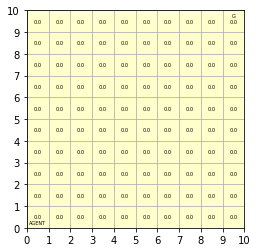

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
textsize = 5

def draw(mark_pos):
    fig, ax = plt.subplots()
    values = [[states[i][j].Q[states[i][j].best_action] for i in range(size)] for j in range(size)]
    mp = ax.pcolor(values, cmap = plt.cm.YlOrRd, vmin = 0, vmax = 8)
    ax.grid()
    ax.set_aspect(1)
    ax.set_xticks(range(size+1), minor = False)
    ax.set_yticks(range(size+1), minor = False)
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            s = states[x][y]
            plt.text(x+0.5, y+0.5, int(1000*s.Q[s.best_action])/1000, ha = 'center', va = 'center', size = textsize)
            if states[x][y].goal:
                plt.text(x+0.5, y+0.75, "G", ha = 'center', va = 'center', size = textsize)
    
    plt.text(agent.pos[0]+0.5, agent.pos[1]+0.25, "AGENT", ha = 'center', va = 'center', size = textsize)

    if mark_pos == "all":
        for x in range(size):
            for y in range(size):
                if states[x][y].goal: continue
                plt.text(x+0.5, y+0.25, states[x][y].best_action, ha = 'center', va = 'center', size = textsize)
    elif mark_pos != None:
        s = states[mark_pos[0]][mark_pos[1]]
        plt.text(mark_pos[0]+0.5, mark_pos[1]+0.25, s.best_action, ha = 'center', va = 'center', size = textsize)

    plt.show()
    fig.clear()

draw(None)

#### State Transitions

In [5]:
import random

def state_transition(s_pos,a):
    if random.uniform(0,1) < 0.1: #Return the same position at a 10% chance
        return s_pos

    x, y = s_pos
    if a == "U": y += 1
    elif a == "D": y -= 1
    elif a == "R": x += 1
    elif a == "L": x -= 1
    elif a == "u_r": 
        if x < size-1 and y < size-1:
            x += 1
            y += 1
    elif a == "u_l":
        if x > 0 and y < size-1:
            x -= 1
            y += 1
    elif a == "d_r":
        if x < size-1 and y > 0:
            x += 1
            y -= 1
    elif a == "d_l":
        if x > 0 and y > 0:
            x -= 1
            y -= 1
    
    if x < 0: x = 0
    elif x >= size: x = size-1
    elif y < 0: y = 0
    elif y >= size: y = size-1
    
    return(x,y)

#### Policy (ε-greedy)

In [6]:
def e_greedy(s):
    if random.uniform(0,1) < 0.1: #Choose something random ata 10% chance
        return random.choice(agent.actions)

    else:
        best_a = None
        best_q = 1000000000
        for a in s.Q:
            if best_q > s.Q[a]:
                best_q = s.Q[a]
                best_a = a
        s.best_action = best_a
        return best_a

#### Processing step by step

s:(3, 9) a:(4, 9) a':U
-----
s:(4, 9) a:(4, 9) a':U
-----
s:(4, 9) a:(4, 9) a':D
-----
s:(4, 9) a:(4, 8) a':U
-----
s:(4, 8) a:(4, 9) a':L
-----
s:(4, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':D
-----
s:(3, 9) a:(3, 8) a':U
-----
s:(3, 8) a:(3, 9) a':L
-----
s:(3, 9) a:(2, 9) a':R
-----
s:(2, 9) a:(3, 9) a':u_r
-----
s:(3, 9) a:(3, 9) a':u_r
-----
s:(3, 9) a:(3, 9) a':u_l
-----
s:(3, 9) a:(3, 9) a':d_l
-----
s:(3, 9) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 8) a':D
-----
s:(2, 8) a:(2, 7) a':U
-----
s:(2, 7) a:(2, 8) a':L
-----
s:(2, 8) a:(1, 8) a':u_r
-----
s:(1, 8) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 8) a':U
-----
s:(1, 8) a:(1, 9) a':L
-----
s:(1, 9) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':D
-----
s:(0, 9) a:(0, 8) a':U
-----
s:(0

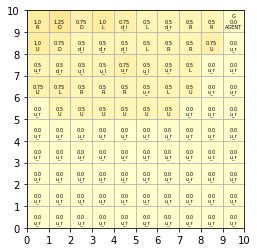

s:(7, 2) a:(7, 2) a':U
-----
s:(7, 2) a:(7, 2) a':D
-----
s:(7, 2) a:(7, 1) a':U
-----
s:(7, 1) a:(7, 2) a':L
-----
s:(7, 2) a:(7, 2) a':L
-----
s:(7, 2) a:(6, 2) a':U
-----
s:(6, 2) a:(6, 3) a':U
-----
s:(6, 3) a:(6, 4) a':U
-----
s:(6, 4) a:(6, 5) a':D
-----
s:(6, 5) a:(6, 4) a':D
-----
s:(6, 4) a:(6, 4) a':D
-----
s:(6, 4) a:(6, 3) a':D
-----
s:(6, 3) a:(6, 2) a':D
-----
s:(6, 2) a:(6, 1) a':U
-----
s:(6, 1) a:(6, 2) a':L
-----
s:(6, 2) a:(5, 2) a':U
-----
s:(5, 2) a:(5, 3) a':U
-----
s:(5, 3) a:(5, 4) a':U
-----
s:(5, 4) a:(5, 5) a':D
-----
s:(5, 5) a:(5, 4) a':D
-----
s:(5, 4) a:(5, 3) a':D
-----
s:(5, 3) a:(5, 2) a':D
-----
s:(5, 2) a:(5, 1) a':U
-----
s:(5, 1) a:(5, 2) a':L
-----
s:(5, 2) a:(5, 2) a':L
-----
s:(5, 2) a:(4, 2) a':u_l
-----
s:(4, 2) a:(3, 3) a':U
-----
s:(3, 3) a:(3, 4) a':U
-----
s:(3, 4) a:(3, 5) a':D
-----
s:(3, 5) a:(3, 4) a':D
-----
s:(3, 4) a:(3, 3) a':D
-----
s:(3, 3) a:(3, 3) a':D
-----
s:(3, 3) a:(3, 2) a':U
-----
s:(3, 2) a:(3, 3) a':L
-----
s:(3, 3) a:(

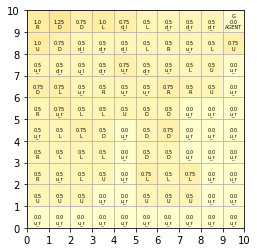

s:(9, 1) a:(9, 2) a':U
-----
s:(9, 2) a:(9, 3) a':U
-----
s:(9, 3) a:(9, 3) a':U
-----
s:(9, 3) a:(9, 4) a':U
-----
s:(9, 4) a:(9, 5) a':U
-----
s:(9, 5) a:(9, 6) a':U
-----
s:(9, 6) a:(9, 7) a':U
-----
s:(9, 7) a:(9, 8) a':D
-----
s:(9, 8) a:(9, 7) a':D
-----
s:(9, 7) a:(9, 6) a':D
-----
s:(9, 6) a:(9, 5) a':D
-----
s:(9, 5) a:(9, 4) a':D
-----
s:(9, 4) a:(9, 3) a':D
-----
s:(9, 3) a:(9, 2) a':D
-----
s:(9, 2) a:(9, 1) a':d_r
-----
s:(9, 1) a:(9, 1) a':D
-----
s:(9, 1) a:(9, 0) a':d_r
-----
s:(9, 0) a:(9, 0) a':U
-----
s:(9, 0) a:(9, 1) a':L
-----
s:(9, 1) a:(8, 1) a':U
-----
s:(8, 1) a:(8, 2) a':U
-----
s:(8, 2) a:(8, 3) a':U
-----
s:(8, 3) a:(8, 4) a':U
-----
s:(8, 4) a:(8, 5) a':U
-----
s:(8, 5) a:(8, 6) a':D
-----
s:(8, 6) a:(8, 5) a':D
-----
s:(8, 5) a:(8, 4) a':D
-----
s:(8, 4) a:(8, 3) a':D
-----
s:(8, 3) a:(8, 2) a':D
-----
s:(8, 2) a:(8, 2) a':D
-----
s:(8, 2) a:(8, 2) a':L
-----
s:(8, 2) a:(7, 2) a':R
-----
s:(7, 2) a:(8, 2) a':R
-----
s:(8, 2) a:(9, 2) a':u_r
-----
s:(9, 2)

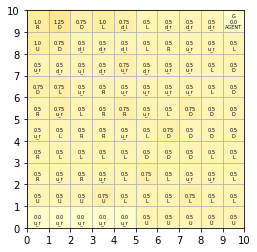

s:(0, 1) a:(0, 0) a':d_l
-----
s:(0, 0) a:(0, 0) a':U
-----
s:(0, 0) a:(0, 1) a':L
-----
s:(0, 1) a:(0, 1) a':L
-----
s:(0, 1) a:(0, 1) a':R
-----
s:(0, 1) a:(1, 1) a':L
-----
s:(1, 1) a:(0, 1) a':R
-----
s:(0, 1) a:(1, 1) a':D
-----
s:(1, 1) a:(1, 0) a':U
-----
s:(1, 0) a:(1, 1) a':R
-----
s:(1, 1) a:(2, 1) a':D
-----
s:(2, 1) a:(2, 0) a':U
-----
s:(2, 0) a:(2, 1) a':L
-----
s:(2, 1) a:(1, 1) a':u_r
-----
s:(1, 1) a:(2, 2) a':L
-----
s:(2, 2) a:(1, 2) a':u_l
-----
s:(1, 2) a:(0, 3) a':u_r
-----
s:(0, 3) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':d_l
-----
s:(0, 3) a:(0, 3) a':d_l
-----
s:(0, 3) a:(0, 3) a':U
-----
s:(0, 3) a:(0, 4) a':u_l
-----
s:(0, 4) a:(0, 4) a':u_l
-----
s:(0, 4) a:(0, 4) a':d_r
-----
s:(0, 4) a:(1, 3) a':R
-----
s:(1, 3) a:(1, 3) a':D
-----
s:(1, 3) a:(1, 3) a':u_r
-----
s:(1, 3) a:(2, 4) a':u_r
-----
s:(2, 4) a:(3, 5) a':u_r
-----
s:(3, 5) a:(3, 5) a':u_r
-----
s:(3, 5) a:(4, 6) a':u_l
-----
s:(4, 6) a:(4, 6) a':u_l
-----
s:(4, 6) a:

s:(0, 5) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':d_r
-----
s:(0, 5) a:(1, 4) a':d_r
-----
s:(1, 4) a:(2, 3) a':u_l
-----
s:(2, 3) a:(2, 3) a':u_l
-----
s:(2, 3) a:(1, 4) a':U
-----
s:(1, 4) a:(1, 5) a':L
-----
s:(1, 5) a:(0, 5) a':d_l
-----
s:(0, 5) a:(0, 5) a':d_l
-----
s:(0, 5) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':d_r
-----
s:(0, 6) a:(1, 5) a':R
-----
s:(1, 5) a:(2, 5) a':R
-----
s:(2, 5) a:(3, 5) a':D
-----
s:(3, 5) a:(3, 4) a':L
-----
s:(3, 4) a:(3, 4) a':u_l
-----
s:(3, 4) a:(2, 5) a':U
-----
s:(2, 5) a:(2, 6) a':u_r
-----
s:(2, 6) a:(3, 7) a':u_l
-----
s:(3, 7) a:(2, 8) a':d_l
-----
s:(2, 8) a:(1, 7) a':R
-----
s:(1, 7) a:(2, 7) a':u_r
-----
s:(2, 7) a:(3, 8) a':d_l
-----
s:(3, 8) a:(2, 7) a':u_l
-----
s:(2, 7) a:(1, 8) a':U
-----
s:(1, 8) a:(1, 8) a':U
-----
s:(1, 8) a:(1, 8) a':D
-----
s:(1, 8) a:(1, 7) a':u_l
-----
s:(1, 7) a:(0, 8) a':u_r
-----
s:(0, 8) a:(0, 8) a':u_r
-----
s:(0, 8) a:(1, 9) a':u_r
-----
s

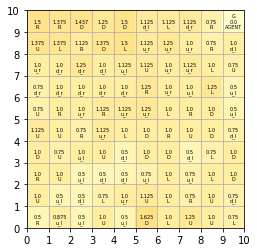

s:(0, 0) a:(1, 1) a':d_r
-----
s:(1, 1) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':U
-----
s:(2, 0) a:(2, 1) a':U
-----
s:(2, 1) a:(2, 2) a':L
-----
s:(2, 2) a:(1, 2) a':L
-----
s:(1, 2) a:(0, 2) a':D
-----
s:(0, 2) a:(0, 1) a':D
-----
s:(0, 1) a:(0, 0) a':u_l
-----
s:(0, 0) a:(0, 0) a':u_l
-----
s:(0, 0) a:(0, 0) a':d_r
-----
s:(0, 0) a:(0, 0) a':d_r
-----
s:(0, 0) a:(0, 0) a':U
-----
s:(0, 0) a:(0, 1) a':u_r
-----
s:(0, 1) a:(0, 1) a':u_r
-----
s:(0, 1) a:(1, 2) a':u_r
-----
s:(1, 2) a:(2, 3) a':L
-----
s:(2, 3) a:(1, 3) a':L
-----
s:(1, 3) a:(1, 3) a':L
-----
s:(1, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':u_r
-----
s:(0, 2) a:(1, 3) a':D
-----
s:(1, 3) a:(1, 2) a':D
-----
s:(1, 2) a:(1, 1) a':d_l
-----
s:(1, 1) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':R
-----
s:(0, 0) a:(1, 0) a':d_r
-----
s:(1, 0) a:(1, 0) a':U
-----
s:(1, 0) a:(1, 1) a':U
-----
s:(1, 1) a:(1, 2) a':R
-----
s:(1, 2) a:

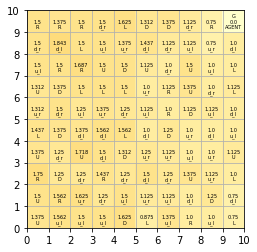

s:(4, 9) a:(5, 9) a':R
-----
s:(5, 9) a:(5, 9) a':R
-----
s:(5, 9) a:(6, 9) a':d_l
-----
s:(6, 9) a:(5, 8) a':U
-----
s:(5, 8) a:(5, 9) a':u_l
-----
s:(5, 9) a:(5, 9) a':u_l
-----
s:(5, 9) a:(5, 9) a':d_r
-----
s:(5, 9) a:(6, 8) a':d_l
-----
s:(6, 8) a:(5, 7) a':D
-----
s:(5, 7) a:(5, 6) a':d_r
-----
s:(5, 6) a:(6, 5) a':u_l
-----
s:(6, 5) a:(5, 6) a':d_l
-----
s:(5, 6) a:(4, 5) a':d_l
-----
s:(4, 5) a:(3, 4) a':U
-----
s:(3, 4) a:(3, 5) a':U
-----
s:(3, 5) a:(3, 6) a':d_r
-----
s:(3, 6) a:(3, 6) a':d_r
-----
s:(3, 6) a:(4, 5) a':L
-----
s:(4, 5) a:(3, 5) a':D
-----
s:(3, 5) a:(3, 4) a':R
-----
s:(3, 4) a:(4, 4) a':R
-----
s:(4, 4) a:(5, 4) a':R
-----
s:(5, 4) a:(6, 4) a':d_l
-----
s:(6, 4) a:(5, 3) a':U
-----
s:(5, 3) a:(5, 4) a':d_l
-----
s:(5, 4) a:(4, 3) a':L
-----
s:(4, 3) a:(3, 3) a':L
-----
s:(3, 3) a:(2, 3) a':D
-----
s:(2, 3) a:(2, 2) a':d_l
-----
s:(2, 2) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':u_r
-----
s:(0, 0) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':d_r
-----
s:(0, 0

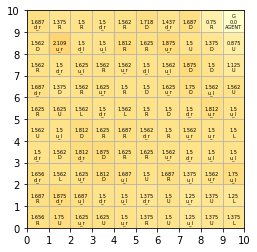

s:(5, 4) a:(4, 5) a':R
-----
s:(4, 5) a:(5, 5) a':d_r
-----
s:(5, 5) a:(5, 5) a':d_r
-----
s:(5, 5) a:(5, 5) a':d_l
-----
s:(5, 5) a:(4, 4) a':U
-----
s:(4, 4) a:(4, 5) a':u_r
-----
s:(4, 5) a:(4, 5) a':u_r
-----
s:(4, 5) a:(5, 6) a':L
-----
s:(5, 6) a:(4, 6) a':d_r
-----
s:(4, 6) a:(4, 6) a':d_r
-----
s:(4, 6) a:(5, 5) a':L
-----
s:(5, 5) a:(4, 5) a':u_l
-----
s:(4, 5) a:(3, 6) a':R
-----
s:(3, 6) a:(4, 6) a':D
-----
s:(4, 6) a:(4, 5) a':d_r
-----
s:(4, 5) a:(4, 5) a':d_r
-----
s:(4, 5) a:(4, 5) a':U
-----
s:(4, 5) a:(4, 6) a':d_l
-----
s:(4, 6) a:(3, 5) a':R
-----
s:(3, 5) a:(4, 5) a':D
-----
s:(4, 5) a:(4, 5) a':D
-----
s:(4, 5) a:(4, 4) a':d_l
-----
s:(4, 4) a:(3, 3) a':d_l
-----
s:(3, 3) a:(2, 2) a':u_l
-----
s:(2, 2) a:(1, 3) a':U
-----
s:(1, 3) a:(1, 4) a':d_l
-----
s:(1, 4) a:(0, 3) a':d_l
-----
s:(0, 3) a:(0, 3) a':d_l
-----
s:(0, 3) a:(0, 3) a':u_r
-----
s:(0, 3) a:(1, 4) a':R
-----
s:(1, 4) a:(2, 4) a':L
-----
s:(2, 4) a:(1, 4) a':d_r
-----
s:(1, 4) a:(2, 3) a':D
-----
s:(2,

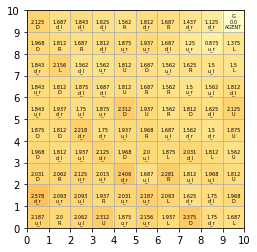

s:(0, 0) a:(1, 0) a':d_r
-----
s:(1, 0) a:(1, 0) a':D
-----
s:(1, 0) a:(1, 0) a':u_l
-----
s:(1, 0) a:(0, 1) a':L
-----
s:(0, 1) a:(0, 1) a':L
-----
s:(0, 1) a:(0, 1) a':R
-----
s:(0, 1) a:(0, 1) a':R
-----
s:(0, 1) a:(0, 1) a':U
-----
s:(0, 1) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':d_r
-----
s:(0, 2) a:(0, 2) a':d_r
-----
s:(0, 2) a:(1, 1) a':u_l
-----
s:(1, 1) a:(1, 1) a':u_l
-----
s:(1, 1) a:(0, 2) a':R
-----
s:(0, 2) a:(1, 2) a':u_l
-----
s:(1, 2) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':R
-----
s:(0, 3) a:(0, 3) a':R
-----
s:(0, 3) a:(1, 3) a':R
-----
s:(1, 3) a:(2, 3) a':u_r
-----
s:(2, 3) a:(3, 4) a':L
-----
s:(3, 4) a:(2, 4) a':d_l
-----
s:(2, 4) a:(1, 3) a':L
-----
s:(1, 3) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':R
-----
s:(0, 3) a:(1, 3) a':D
-----
s:(1, 3) a:(1, 2) a':U
-----
s:(1, 2) a:(1, 3) a':u_r
-----
s:(1, 3) a:(1, 3) a':u_r
-----
s:(1, 3) a:(2, 4) a':u_l
-----
s:(2, 4) a:(2, 4) a':u_l
-----
s:(2, 4) a:(1

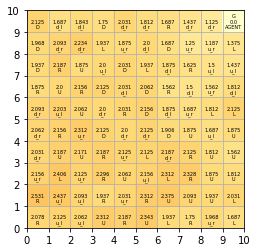

s:(2, 7) a:(2, 6) a':u_l
-----
s:(2, 6) a:(1, 7) a':d_l
-----
s:(1, 7) a:(1, 7) a':u_r
-----
s:(1, 7) a:(2, 8) a':d_l
-----
s:(2, 8) a:(2, 8) a':d_l
-----
s:(2, 8) a:(2, 8) a':D
-----
s:(2, 8) a:(2, 7) a':L
-----
s:(2, 7) a:(1, 7) a':d_r
-----
s:(1, 7) a:(2, 6) a':d_r
-----
s:(2, 6) a:(2, 6) a':d_r
-----
s:(2, 6) a:(3, 5) a':D
-----
s:(3, 5) a:(3, 4) a':L
-----
s:(3, 4) a:(3, 4) a':u_r
-----
s:(3, 4) a:(3, 4) a':u_r
-----
s:(3, 4) a:(4, 5) a':d_l
-----
s:(4, 5) a:(3, 4) a':d_l
-----
s:(3, 4) a:(2, 3) a':L
-----
s:(2, 3) a:(1, 3) a':d_r
-----
s:(1, 3) a:(2, 2) a':u_l
-----
s:(2, 2) a:(1, 3) a':d_l
-----
s:(1, 3) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':U
-----
s:(0, 2) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':u_r
-----
s:(0, 3) a:(1, 4) a':u_r
-----
s:(1, 4) a:(2, 5) a':D
-----
s:(2, 5) a:(2, 4) a':L
-----
s:(2, 4) a:(1, 4) a':d_r
-----
s:(1, 4) a:(2, 3) a':d_l
-----
s:(2, 3) a:(2, 3) a':d_l
-----
s:(2, 3) a:(1, 2) a':u_l

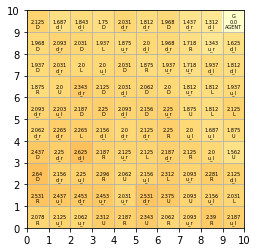

s:(1, 9) a:(0, 9) a':d_l
-----
s:(0, 9) a:(0, 9) a':d_l
-----
s:(0, 9) a:(0, 9) a':L
-----
s:(0, 9) a:(0, 9) a':L
-----
s:(0, 9) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':R
-----
s:(1, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':u_r
-----
s:(1, 9) a:(1, 9) a':u_r
-----
s:(1, 9) a:(1, 9) a':d_r
-----
s:(1, 9) a:(2, 8) a':R
-----
s:(2, 8) a:(3, 8) a':U
-----
s:(3, 8) a:(3, 9) a':L
-----
s:(3, 9) a:(2, 9) a':R
-----
s:(2, 9) a:(3, 9) a':R
-----
s:(3, 9) a:(4, 9) a':d_l
-----
s:(4, 9) a:(3, 8) a':u_l
-----
s:(3, 8) a:(2, 9) a':u_r
-----
s:(2, 9) a:(2, 9) a':u_r
-----
s:(2, 9) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':d_r
-----
s:(2, 9) a:(3, 8) a':u_r
-----
s:(3, 8) a:(4, 9) a':U
-----
s:(4, 9) a:(4, 9) a':U
-----
s:(4, 9) a:(4, 9) a':u_r
-----
s:(4, 9) a:(4, 9) a':u_r
-----
s:(4, 9) a:(4

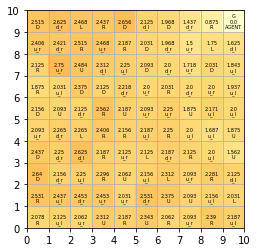

s:(2, 7) a:(2, 7) a':L
-----
s:(2, 7) a:(1, 7) a':D
-----
s:(1, 7) a:(1, 6) a':D
-----
s:(1, 6) a:(1, 6) a':D
-----
s:(1, 6) a:(1, 5) a':R
-----
s:(1, 5) a:(1, 5) a':R
-----
s:(1, 5) a:(2, 5) a':d_l
-----
s:(2, 5) a:(1, 4) a':U
-----
s:(1, 4) a:(1, 5) a':u_r
-----
s:(1, 5) a:(2, 6) a':R
-----
s:(2, 6) a:(3, 6) a':u_l
-----
s:(3, 6) a:(2, 7) a':U
-----
s:(2, 7) a:(2, 8) a':d_r
-----
s:(2, 8) a:(3, 7) a':U
-----
s:(3, 7) a:(3, 8) a':u_l
-----
s:(3, 8) a:(2, 9) a':R
-----
s:(2, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':L
-----
s:(3, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 8) a':u_r
-----
s:(2, 8) a:(2, 8) a':u_r
-----
s:(2, 8) a:(3, 9) a':d_l
-----
s:(3, 9) a:(3, 9) a':d_l
-----
s:(3, 9) a:(2, 8) a':d_l
-----
s:(2, 8) a:(1, 7) a':d_r
-----
s:(1, 7) a:(1, 7) a':d_r
-----
s:(1, 7) a:(1, 7) a':L
-----
s:(1, 7) a:(0, 7) a':L
-----
s:(0, 7) a:(0, 7) a':L
-----
s:(0, 7) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':d_r
-----
s:(0, 7) a:(1

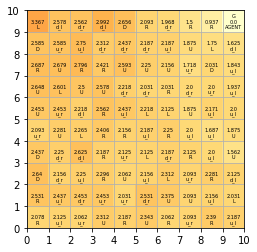

s:(4, 3) a:(3, 4) a':u_l
-----
s:(3, 4) a:(2, 5) a':u_l
-----
s:(2, 5) a:(1, 6) a':u_l
-----
s:(1, 6) a:(0, 7) a':u_r
-----
s:(0, 7) a:(0, 7) a':u_r
-----
s:(0, 7) a:(1, 8) a':L
-----
s:(1, 8) a:(0, 8) a':d_r
-----
s:(0, 8) a:(1, 7) a':u_l
-----
s:(1, 7) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':u_r
-----
s:(0, 8) a:(1, 9) a':u_r
-----
s:(1, 9) a:(1, 9) a':u_r
-----
s:(1, 9) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 8) a':U
-----
s:(1, 8) a:(1, 9) a':R
-----
s:(1, 9) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':L
-----
s:(1, 9) a:(0, 9) a':d_r
-----
s:(0, 9) a:(1, 8) a':R
-----
s:(1, 8) a:(2, 8) a':D
-----
s:(2, 8) a:(2, 7) a':u_l
-----
s:(2, 7) a:(1, 8) a':u_l
-----
s:(1, 8) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':d_l
-----
s:(1, 9) a:(0, 8) a':R
-----
s:(0, 8) a:(1, 8) a':d_r
-----
s:(1, 8) a:(2, 7) a':D
-----
s:(2, 7) a:(2, 6) a':L
-----
s:(2, 6) a:(1

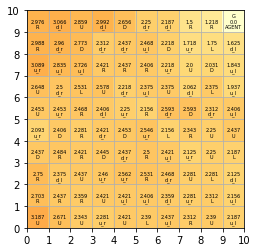

s:(9, 1) a:(9, 2) a':u_l
-----
s:(9, 2) a:(8, 3) a':D
-----
s:(8, 3) a:(8, 2) a':d_r
-----
s:(8, 2) a:(9, 1) a':D
-----
s:(9, 1) a:(9, 0) a':U
-----
s:(9, 0) a:(9, 1) a':R
-----
s:(9, 1) a:(9, 1) a':R
-----
s:(9, 1) a:(9, 1) a':L
-----
s:(9, 1) a:(8, 1) a':U
-----
s:(8, 1) a:(8, 2) a':D
-----
s:(8, 2) a:(8, 1) a':d_r
-----
s:(8, 1) a:(9, 0) a':d_l
-----
s:(9, 0) a:(9, 0) a':d_l
-----
s:(9, 0) a:(9, 0) a':L
-----
s:(9, 0) a:(8, 0) a':u_r
-----
s:(8, 0) a:(9, 1) a':d_r
-----
s:(9, 1) a:(9, 1) a':d_r
-----
s:(9, 1) a:(9, 1) a':d_l
-----
s:(9, 1) a:(8, 0) a':u_l
-----
s:(8, 0) a:(7, 1) a':L
-----
s:(7, 1) a:(6, 1) a':D
-----
s:(6, 1) a:(6, 1) a':D
-----
s:(6, 1) a:(6, 0) a':U
-----
s:(6, 0) a:(6, 1) a':u_l
-----
s:(6, 1) a:(5, 2) a':D
-----
s:(5, 2) a:(5, 1) a':D
-----
s:(5, 1) a:(5, 0) a':u_l
-----
s:(5, 0) a:(4, 1) a':U
-----
s:(4, 1) a:(4, 2) a':U
-----
s:(4, 2) a:(4, 3) a':D
-----
s:(4, 3) a:(4, 2) a':L
-----
s:(4, 2) a:(3, 2) a':u_l
-----
s:(3, 2) a:(2, 3) a':u_r
-----
s:(2, 3) a:(3, 

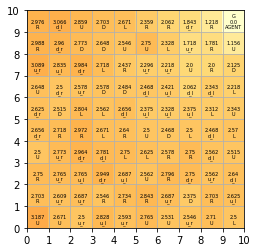

s:(9, 1) a:(9, 2) a':U
-----
s:(9, 2) a:(9, 3) a':d_l
-----
s:(9, 3) a:(8, 2) a':d_l
-----
s:(8, 2) a:(7, 1) a':U
-----
s:(7, 1) a:(7, 2) a':U
-----
s:(7, 2) a:(7, 3) a':u_r
-----
s:(7, 3) a:(8, 4) a':L
-----
s:(8, 4) a:(7, 4) a':u_l
-----
s:(7, 4) a:(6, 5) a':U
-----
s:(6, 5) a:(6, 6) a':D
-----
s:(6, 6) a:(6, 5) a':d_l
-----
s:(6, 5) a:(5, 4) a':d_r
-----
s:(5, 4) a:(6, 3) a':D
-----
s:(6, 3) a:(6, 2) a':u_l
-----
s:(6, 2) a:(5, 3) a':d_r
-----
s:(5, 3) a:(6, 2) a':U
-----
s:(6, 2) a:(6, 3) a':U
-----
s:(6, 3) a:(6, 3) a':U
-----
s:(6, 3) a:(6, 4) a':u_r
-----
s:(6, 4) a:(7, 5) a':U
-----
s:(7, 5) a:(7, 6) a':D
-----
s:(7, 6) a:(7, 5) a':d_r
-----
s:(7, 5) a:(8, 4) a':d_r
-----
s:(8, 4) a:(9, 3) a':L
-----
s:(9, 3) a:(8, 3) a':u_l
-----
s:(8, 3) a:(7, 4) a':d_r
-----
s:(7, 4) a:(8, 3) a':R
-----
s:(8, 3) a:(9, 3) a':D
-----
s:(9, 3) a:(9, 2) a':u_l
-----
s:(9, 2) a:(8, 3) a':U
-----
s:(8, 3) a:(8, 4) a':D
-----
s:(8, 4) a:(8, 4) a':D
-----
s:(8, 4) a:(8, 3) a':D
-----
s:(8, 3) a:(8, 

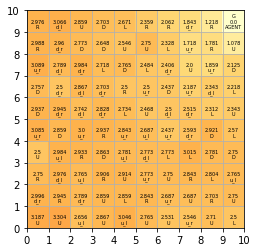

s:(5, 9) a:(5, 9) a':d_l
-----
s:(5, 9) a:(4, 8) a':D
-----
s:(4, 8) a:(4, 7) a':L
-----
s:(4, 7) a:(3, 7) a':d_r
-----
s:(3, 7) a:(4, 6) a':U
-----
s:(4, 6) a:(4, 7) a':u_r
-----
s:(4, 7) a:(5, 8) a':d_l
-----
s:(5, 8) a:(4, 7) a':d_r
-----
s:(4, 7) a:(5, 6) a':d_r
-----
s:(5, 6) a:(6, 5) a':D
-----
s:(6, 5) a:(6, 4) a':L
-----
s:(6, 4) a:(6, 4) a':L
-----
s:(6, 4) a:(5, 4) a':d_l
-----
s:(5, 4) a:(4, 3) a':d_l
-----
s:(4, 3) a:(3, 2) a':U
-----
s:(3, 2) a:(3, 3) a':L
-----
s:(3, 3) a:(2, 3) a':D
-----
s:(2, 3) a:(2, 2) a':d_l
-----
s:(2, 2) a:(1, 1) a':u_l
-----
s:(1, 1) a:(0, 2) a':u_r
-----
s:(0, 2) a:(1, 3) a':d_l
-----
s:(1, 3) a:(0, 2) a':U
-----
s:(0, 2) a:(0, 3) a':u_r
-----
s:(0, 3) a:(1, 4) a':d_l
-----
s:(1, 4) a:(0, 3) a':R
-----
s:(0, 3) a:(1, 3) a':L
-----
s:(1, 3) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':D
-----
s:(0, 2) a:(0, 1) a':d_l
-----
s:(0,

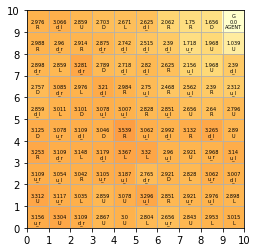

s:(0, 3) a:(1, 4) a':R
-----
s:(1, 4) a:(2, 4) a':U
-----
s:(2, 4) a:(2, 5) a':d_r
-----
s:(2, 5) a:(3, 4) a':L
-----
s:(3, 4) a:(2, 4) a':L
-----
s:(2, 4) a:(1, 4) a':L
-----
s:(1, 4) a:(1, 4) a':L
-----
s:(1, 4) a:(1, 4) a':u_l
-----
s:(1, 4) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':d_l
-----
s:(0, 6) a:(0, 6) a':d_l
-----
s:(0, 6) a:(0, 6) a':R
-----
s:(0, 6) a:(1, 6) a':d_l
-----
s:(1, 6) a:(0, 5) a':R
-----
s:(0, 5) a:(1, 5) a':u_l
-----
s:(1, 5) a:(0, 6) a':u_r
-----
s:(0, 6) a:(1, 7) a':D
-----
s:(1, 7) a:(1, 6) a':u_l
-----
s:(1, 6) a:(0, 7) a':L
-----
s:(0, 7) a:(0, 7) a':L
-----
s:(0, 7) a:(0, 7) a':U
-----
s:(0, 7) a:(0, 8) a':D
-----
s:(0, 8) a:(0, 7) a':d_r
-----
s:(0, 7) a:(1, 6) a':L
-----
s:(1, 6) a:(0, 6) a':U
-----
s:(0, 6) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':D
-----
s:(0, 7) a:(0, 6) a':d_r
-----
s:(0, 6) a:(1, 

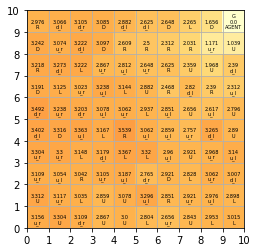

s:(3, 7) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 8) a':u_l
-----
s:(2, 8) a:(1, 9) a':d_r
-----
s:(1, 9) a:(2, 8) a':D
-----
s:(2, 8) a:(2, 7) a':d_l
-----
s:(2, 7) a:(1, 6) a':R
-----
s:(1, 6) a:(2, 6) a':u_l
-----
s:(2, 6) a:(1, 7) a':u_l
-----
s:(1, 7) a:(0, 8) a':U
-----
s:(0, 8) a:(0, 9) a':u_l
-----
s:(0, 9) a:(0, 9) a':u_l
-----
s:(0, 9) a:(0, 9) a':d_r
-----
s:(0, 9) a:(1, 8) a':U
-----
s:(1, 8) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':R
-----
s:(1, 9) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':d_r
-----
s:(2, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':L
-----
s:(1, 9) a:(0, 9) a':u_r
-----
s:(0, 9) a:(0, 9) a':u_r
-----
s:(0, 9) a:(0, 9) a':D
-----
s:(0, 9) a:(0, 8) a':d_r
-----
s:(0, 8) a:(1, 7) a':d_r
-----
s:(1, 7) a:(2, 6) a':d_l
-----
s:(2, 6) a:(1, 5) a':d_r
-----
s:(1,

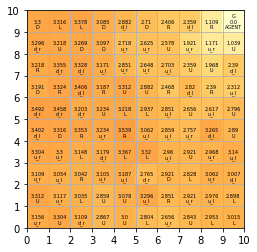

s:(1, 5) a:(0, 5) a':d_l
-----
s:(0, 5) a:(0, 5) a':D
-----
s:(0, 5) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':u_r
-----
s:(0, 6) a:(1, 7) a':L
-----
s:(1, 7) a:(0, 7) a':u_l
-----
s:(0, 7) a:(0, 7) a':u_l
-----
s:(0, 7) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':D
-----
s:(0, 7) a:(0, 6) a':R
-----
s:(0, 6) a:(1, 6) a':u_l
-----
s:(1, 6) a:(0, 7) a':U
-----
s:(0, 7) a:(0, 8) a':u_l
-----
s:(0, 8) a:(0, 8) a':u_l
-----
s:(0, 8) a:(0, 8) a':u_r
-----
s:(0, 8) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 8) a':u_l
-----
s:(1, 8) a:(0, 9) a':d_l
-----
s:(0, 9) a:(0, 9) a':d_l
-----
s:(0, 9) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':d_l
-----
s:(1, 9) a:(0, 8) a':d_l
-----
s:(0, 8) a:(0, 8) a':d_l
-----
s:(0, 8) a:(0, 8) a':R
-----
s:(0, 8) a:(0, 8) a':R
-----
s:(0, 8) a:(1, 8) a':R
-----
s:(1, 8) a:(2, 8) a':L
-----
s:(2, 8) a:(1, 8) a':L
-----
s:(1, 8) a:(1, 8) a':L
-----
s:(1, 8) a:(0, 8) a':U
-----
s:(0, 8) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':U
-----
s:(0, 9) a:

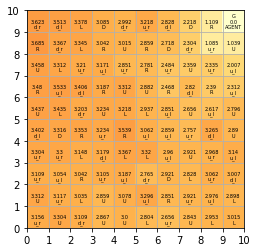

s:(7, 5) a:(8, 5) a':u_r
-----
s:(8, 5) a:(9, 6) a':U
-----
s:(9, 6) a:(9, 7) a':d_r
-----
s:(9, 7) a:(9, 7) a':d_r
-----
s:(9, 7) a:(9, 7) a':d_l
-----
s:(9, 7) a:(8, 6) a':U
-----
s:(8, 6) a:(8, 6) a':U
-----
s:(8, 6) a:(8, 6) a':u_l
-----
s:(8, 6) a:(7, 7) a':u_r
-----
s:(7, 7) a:(7, 7) a':u_r
-----
s:(7, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


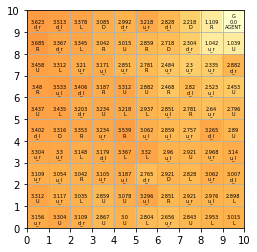

s:(7, 2) a:(8, 2) a':U
-----
s:(8, 2) a:(8, 3) a':u_l
-----
s:(8, 3) a:(7, 4) a':u_l
-----
s:(7, 4) a:(6, 5) a':u_r
-----
s:(6, 5) a:(7, 6) a':R
-----
s:(7, 6) a:(8, 6) a':d_r
-----
s:(8, 6) a:(9, 5) a':u_l
-----
s:(9, 5) a:(8, 6) a':d_l
-----
s:(8, 6) a:(7, 5) a':D
-----
s:(7, 5) a:(7, 4) a':D
-----
s:(7, 4) a:(7, 3) a':u_r
-----
s:(7, 3) a:(8, 4) a':L
-----
s:(8, 4) a:(7, 4) a':L
-----
s:(7, 4) a:(6, 4) a':d_r
-----
s:(6, 4) a:(7, 3) a':d_l
-----
s:(7, 3) a:(6, 2) a':L
-----
s:(6, 2) a:(5, 2) a':R
-----
s:(5, 2) a:(6, 2) a':d_r
-----
s:(6, 2) a:(7, 1) a':D
-----
s:(7, 1) a:(7, 0) a':d_r
-----
s:(7, 0) a:(7, 0) a':L
-----
s:(7, 0) a:(6, 0) a':D
-----
s:(6, 0) a:(6, 0) a':D
-----
s:(6, 0) a:(6, 0) a':d_r
-----
s:(6, 0) a:(6, 0) a':d_r
-----
s:(6, 0) a:(6, 0) a':L
-----
s:(6, 0) a:(5, 0) a':D
-----
s:(5, 0) a:(5, 0) a':D
-----
s:(5, 0) a:(5, 0) a':u_l
-----
s:(5, 0) a:(4, 1) a':d_l
-----
s:(4, 1) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':L
-----
s:(3, 0) 

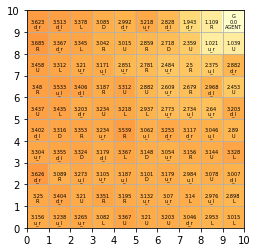

s:(6, 7) a:(5, 6) a':u_r
-----
s:(5, 6) a:(6, 7) a':D
-----
s:(6, 7) a:(6, 6) a':d_r
-----
s:(6, 6) a:(7, 5) a':L
-----
s:(7, 5) a:(6, 5) a':U
-----
s:(6, 5) a:(6, 6) a':d_l
-----
s:(6, 6) a:(5, 5) a':R
-----
s:(5, 5) a:(5, 5) a':u_l
-----
s:(5, 5) a:(4, 6) a':d_l
-----
s:(4, 6) a:(3, 5) a':D
-----
s:(3, 5) a:(3, 4) a':d_r
-----
s:(3, 4) a:(4, 3) a':u_l
-----
s:(4, 3) a:(3, 4) a':U
-----
s:(3, 4) a:(3, 4) a':U
-----
s:(3, 4) a:(3, 5) a':d_r
-----
s:(3, 5) a:(4, 4) a':u_r
-----
s:(4, 4) a:(5, 5) a':d_l
-----
s:(5, 5) a:(4, 4) a':d_r
-----
s:(4, 4) a:(5, 3) a':d_l
-----
s:(5, 3) a:(4, 2) a':d_l
-----
s:(4, 2) a:(3, 1) a':D
-----
s:(3, 1) a:(3, 0) a':u_l
-----
s:(3, 0) a:(2, 1) a':u_l
-----
s:(2, 1) a:(1, 2) a':U
-----
s:(1, 2) a:(1, 3) a':L
-----
s:(1, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':u_r
-----
s:(0, 2) a:(1, 3) a':u_l
-----
s:(1, 3) a:(0, 4) a':U
-----
s:(0, 4) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':u_r
-----
s:(0, 5) a:(1, 6) a':U
-----
s:(1, 6) a:(1, 6) a':U
-----
s:(1, 6

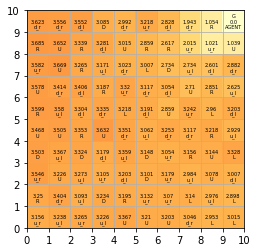

s:(6, 1) a:(6, 0) a':u_r
-----
s:(6, 0) a:(7, 1) a':d_l
-----
s:(7, 1) a:(6, 0) a':d_l
-----
s:(6, 0) a:(6, 0) a':d_l
-----
s:(6, 0) a:(6, 0) a':R
-----
s:(6, 0) a:(7, 0) a':u_r
-----
s:(7, 0) a:(8, 1) a':D
-----
s:(8, 1) a:(8, 0) a':d_r
-----
s:(8, 0) a:(8, 0) a':d_r
-----
s:(8, 0) a:(8, 0) a':u_l
-----
s:(8, 0) a:(7, 1) a':u_l
-----
s:(7, 1) a:(6, 2) a':d_l
-----
s:(6, 2) a:(6, 2) a':d_l
-----
s:(6, 2) a:(5, 1) a':R
-----
s:(5, 1) a:(6, 1) a':U
-----
s:(6, 1) a:(6, 2) a':u_l
-----
s:(6, 2) a:(5, 3) a':d_r
-----
s:(5, 3) a:(5, 3) a':d_r
-----
s:(5, 3) a:(6, 2) a':U
-----
s:(6, 2) a:(6, 3) a':R
-----
s:(6, 3) a:(7, 3) a':d_r
-----
s:(7, 3) a:(8, 2) a':d_l
-----
s:(8, 2) a:(7, 1) a':U
-----
s:(7, 1) a:(7, 2) a':U
-----
s:(7, 2) a:(7, 3) a':U
-----
s:(7, 3) a:(7, 4) a':d_l
-----
s:(7, 4) a:(6, 3) a':D
-----
s:(6, 3) a:(6, 2) a':R
-----
s:(6, 2) a:(7, 2) a':d_r
-----
s:(7, 2) a:(8, 1) a':u_r
-----
s:(8, 1) a:(9, 2) a':u_l
-----
s:(9, 2) a:(9, 2) a':d_l
-----
s:(9, 2) a:(9, 2) a':D
-----
s

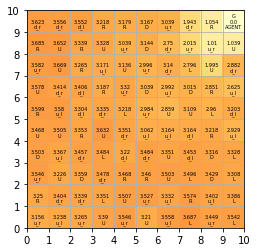

s:(9, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


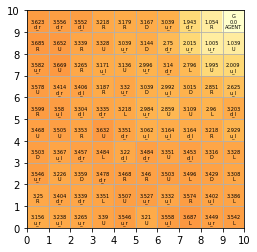

s:(2, 4) a:(3, 3) a':u_l
-----
s:(3, 3) a:(2, 4) a':d_l
-----
s:(2, 4) a:(1, 3) a':R
-----
s:(1, 3) a:(2, 3) a':u_r
-----
s:(2, 3) a:(3, 4) a':R
-----
s:(3, 4) a:(4, 4) a':u_l
-----
s:(4, 4) a:(4, 4) a':u_l
-----
s:(4, 4) a:(3, 5) a':d_l
-----
s:(3, 5) a:(2, 4) a':U
-----
s:(2, 4) a:(2, 5) a':L
-----
s:(2, 5) a:(1, 5) a':D
-----
s:(1, 5) a:(1, 4) a':d_l
-----
s:(1, 4) a:(0, 3) a':d_r
-----
s:(0, 3) a:(1, 2) a':d_r
-----
s:(1, 2) a:(2, 1) a':d_l
-----
s:(2, 1) a:(1, 0) a':d_l
-----
s:(1, 0) a:(1, 0) a':d_l
-----
s:(1, 0) a:(1, 0) a':R
-----
s:(1, 0) a:(2, 0) a':R
-----
s:(2, 0) a:(3, 0) a':D
-----
s:(3, 0) a:(3, 0) a':D
-----
s:(3, 0) a:(3, 0) a':d_l
-----
s:(3, 0) a:(3, 0) a':d_l
-----
s:(3, 0) a:(3, 0) a':L
-----
s:(3, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':D
-----
s:(2, 0) a:(2, 0) a':u_l
-----
s:(2, 0) a:(1, 1) a':D
-----
s:(1, 1) a:(1, 0) a':L
-----
s:(1, 0) a:(0, 0) a':R
-----
s:(0, 0) a:(0, 0) a':R
-----
s:(0, 0

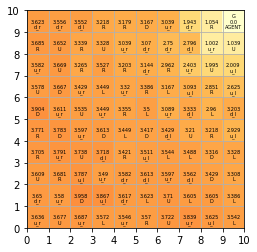

s:(0, 0) a:(0, 1) a':u_l
-----
s:(0, 1) a:(0, 1) a':D
-----
s:(0, 1) a:(0, 0) a':d_l
-----
s:(0, 0) a:(0, 0) a':d_l
-----
s:(0, 0) a:(0, 0) a':u_l
-----
s:(0, 0) a:(0, 0) a':u_l
-----
s:(0, 0) a:(0, 0) a':u_r
-----
s:(0, 0) a:(1, 1) a':U
-----
s:(1, 1) a:(1, 2) a':D
-----
s:(1, 2) a:(1, 1) a':u_l
-----
s:(1, 1) a:(0, 2) a':R
-----
s:(0, 2) a:(1, 2) a':L
-----
s:(1, 2) a:(0, 2) a':D
-----
s:(0, 2) a:(0, 1) a':L
-----
s:(0, 1) a:(0, 1) a':L
-----
s:(0, 1) a:(0, 1) a':R
-----
s:(0, 1) a:(1, 1) a':d_r
-----
s:(1, 1) a:(2, 0) a':R
-----
s:(2, 0) a:(2, 0) a':R
-----
s:(2, 0) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':u_l
-----
s:(3, 0) a:(3, 0) a':u_l
-----
s:(3, 0) a:(2, 1) a':R
-----
s:(2, 1) a:(3, 1) a':D
-----
s:(3, 1) a:(3, 0) a':U
-----
s:(3, 0) a:(3, 1) a':u_r
-----
s:(3, 1) a:(4, 2) a':u_r
-----
s:(4, 2) a:(5, 3) a':D
-----
s:(5, 3) a:(5, 2) a':D
-----
s:(5, 2) a:(5, 1) a':d_l
-----
s:(5, 1) a:(4, 0) a':D
-----
s:(4, 0) a:(4, 0) a':D
-----
s:(4, 0) a:(4

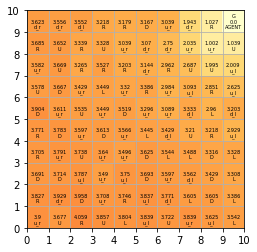

s:(2, 0) a:(2, 1) a':R
-----
s:(2, 1) a:(3, 1) a':L
-----
s:(3, 1) a:(2, 1) a':u_l
-----
s:(2, 1) a:(1, 2) a':U
-----
s:(1, 2) a:(1, 3) a':D
-----
s:(1, 3) a:(1, 2) a':u_r
-----
s:(1, 2) a:(2, 3) a':D
-----
s:(2, 3) a:(2, 2) a':U
-----
s:(2, 2) a:(2, 3) a':R
-----
s:(2, 3) a:(3, 3) a':D
-----
s:(3, 3) a:(3, 2) a':D
-----
s:(3, 2) a:(3, 1) a':R
-----
s:(3, 1) a:(4, 1) a':L
-----
s:(4, 1) a:(3, 1) a':d_r
-----
s:(3, 1) a:(4, 0) a':d_l
-----
s:(4, 0) a:(4, 0) a':d_l
-----
s:(4, 0) a:(4, 0) a':U
-----
s:(4, 0) a:(4, 1) a':D
-----
s:(4, 1) a:(4, 0) a':u_r
-----
s:(4, 0) a:(5, 1) a':R
-----
s:(5, 1) a:(6, 1) a':L
-----
s:(6, 1) a:(5, 1) a':U
-----
s:(5, 1) a:(5, 2) a':U
-----
s:(5, 2) a:(5, 3) a':U
-----
s:(5, 3) a:(5, 4) a':R
-----
s:(5, 4) a:(5, 4) a':R
-----
s:(5, 4) a:(6, 4) a':u_r
-----
s:(6, 4) a:(7, 5) a':u_l
-----
s:(7, 5) a:(6, 6) a':U
-----
s:(6, 6) a:(6, 7) a':u_l
-----
s:(6, 7) a:(5, 8) a':U
-----
s:(5, 8) a:(5, 8) a':U
-----
s:(5, 8) a:(5, 9) a':d_r
-----
s:(5, 9) a:(6, 8) a':d_

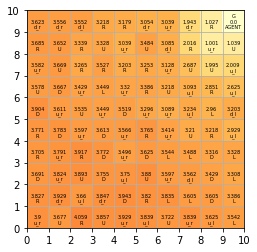

s:(1, 6) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':d_l
-----
s:(0, 6) a:(0, 6) a':d_l
-----
s:(0, 6) a:(0, 6) a':D
-----
s:(0, 6) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':d_r
-----
s:(0, 6) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':u_r
-----
s:(0, 6) a:(1, 7) a':u_r
-----
s:(1, 7) a:(2, 8) a':u_r
-----
s:(2, 8) a:(2, 8) a':u_r
-----
s:(2, 8) a:(3, 9) a':d_r
-----
s:(3, 9) a:(4, 8) a':u_l
-----
s:(4, 8) a:(3, 9) a':d_l
-----
s:(3, 9) a:(2, 8) a':d_r
-----
s:(2, 8) a:(3, 7) a':d_l
-----
s:(3, 7) a:(2, 6) a':R
-----
s:(2, 6) a:(3, 6) a':u_r
-----
s:(3, 6) a:(4, 7) a':d_l
-----
s:(4, 7) a:(3, 6) a':D
-----
s:(3, 6) a:(3, 5) a':L
-----
s:(3, 5) a:(2, 5) a':D
-----
s:(2, 5) a:(2, 4) a':d_l
-----
s:(2, 4) a:(1, 3) a':d_l
-----
s:(1, 3) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':L
-----
s:(0, 2) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':u_r
-----
s:(0, 2) a:(1, 3) a':u

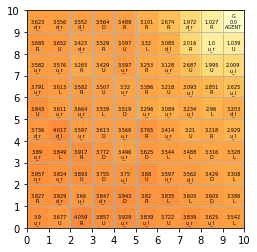

s:(4, 9) a:(4, 8) a':u_r
-----
s:(4, 8) a:(5, 9) a':U
-----
s:(5, 9) a:(5, 9) a':U
-----
s:(5, 9) a:(5, 9) a':d_r
-----
s:(5, 9) a:(5, 9) a':d_r
-----
s:(5, 9) a:(6, 8) a':D
-----
s:(6, 8) a:(6, 7) a':D
-----
s:(6, 7) a:(6, 6) a':D
-----
s:(6, 6) a:(6, 5) a':u_l
-----
s:(6, 5) a:(5, 6) a':U
-----
s:(5, 6) a:(5, 7) a':d_l
-----
s:(5, 7) a:(4, 6) a':u_l
-----
s:(4, 6) a:(3, 7) a':u_l
-----
s:(3, 7) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 9) a':R
-----
s:(2, 9) a:(3, 9) a':L
-----
s:(3, 9) a:(2, 9) a':u_r
-----
s:(2, 9) a:(2, 9) a':u_r
-----
s:(2, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':L
-----
s:(1, 9) a:(0, 9) a':D
-----
s:(0, 9) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':u_l
-----
s:(0, 8) a:(0, 8) a':D
-----
s:(0, 8) a:(0, 7) a':R
-----
s:(0, 7) a:(1, 7) a':R
-----
s:(1, 7) a:(2, 7) a':u_l
-----
s:(2, 7) a:(1, 8) a':u_r
-----
s:(1, 8) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 

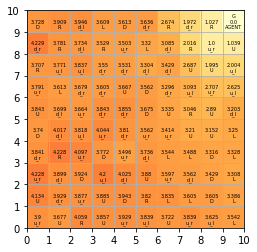

s:(4, 3) a:(3, 2) a':d_r
-----
s:(3, 2) a:(4, 1) a':u_l
-----
s:(4, 1) a:(3, 2) a':u_r
-----
s:(3, 2) a:(4, 3) a':d_r
-----
s:(4, 3) a:(5, 2) a':u_l
-----
s:(5, 2) a:(5, 2) a':u_l
-----
s:(5, 2) a:(4, 3) a':L
-----
s:(4, 3) a:(3, 3) a':U
-----
s:(3, 3) a:(3, 4) a':d_l
-----
s:(3, 4) a:(2, 3) a':u_l
-----
s:(2, 3) a:(1, 4) a':U
-----
s:(1, 4) a:(1, 5) a':R
-----
s:(1, 5) a:(2, 5) a':d_r
-----
s:(2, 5) a:(3, 4) a':d_r
-----
s:(3, 4) a:(4, 3) a':R
-----
s:(4, 3) a:(5, 3) a':L
-----
s:(5, 3) a:(4, 3) a':U
-----
s:(4, 3) a:(4, 3) a':U
-----
s:(4, 3) a:(4, 4) a':U
-----
s:(4, 4) a:(4, 5) a':u_r
-----
s:(4, 5) a:(5, 6) a':d_r
-----
s:(5, 6) a:(6, 5) a':L
-----
s:(6, 5) a:(5, 5) a':R
-----
s:(5, 5) a:(6, 5) a':d_r
-----
s:(6, 5) a:(6, 5) a':d_r
-----
s:(6, 5) a:(7, 4) a':u_r
-----
s:(7, 4) a:(8, 5) a':D
-----
s:(8, 5) a:(8, 4) a':L
-----
s:(8, 4) a:(7, 4) a':u_l
-----
s:(7, 4) a:(6, 5) a':d_l
-----
s:(6, 5) a:(5, 4) a':u_l
-----
s:(5, 4) a:(4, 5) a':D
-----
s:(4, 5) a:(4, 4) a':L
-----
s:(4, 4

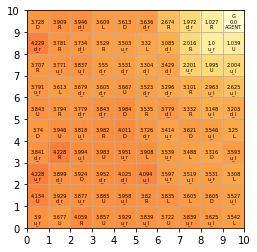

s:(3, 9) a:(3, 9) a':u_l
-----
s:(3, 9) a:(3, 9) a':R
-----
s:(3, 9) a:(4, 9) a':d_r
-----
s:(4, 9) a:(4, 9) a':d_r
-----
s:(4, 9) a:(5, 8) a':d_r
-----
s:(5, 8) a:(6, 7) a':U
-----
s:(6, 7) a:(6, 8) a':u_r
-----
s:(6, 8) a:(7, 9) a':d_r
-----
s:(7, 9) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


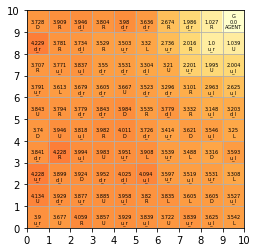

s:(5, 9) a:(5, 9) a':L
-----
s:(5, 9) a:(4, 9) a':R
-----
s:(4, 9) a:(5, 9) a':R
-----
s:(5, 9) a:(6, 9) a':u_l
-----
s:(6, 9) a:(6, 9) a':u_l
-----
s:(6, 9) a:(6, 9) a':U
-----
s:(6, 9) a:(6, 9) a':d_r
-----
s:(6, 9) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


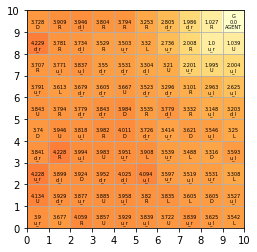

s:(3, 9) a:(4, 8) a':R
-----
s:(4, 8) a:(5, 8) a':R
-----
s:(5, 8) a:(6, 8) a':U
-----
s:(6, 8) a:(6, 9) a':D
-----
s:(6, 9) a:(6, 8) a':R
-----
s:(6, 8) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':u_r
-----


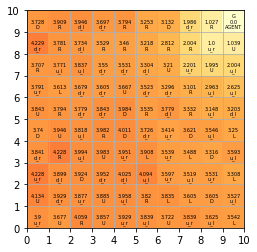

s:(4, 0) a:(3, 0) a':u_r
-----
s:(3, 0) a:(4, 1) a':d_l
-----
s:(4, 1) a:(4, 1) a':d_l
-----
s:(4, 1) a:(3, 0) a':L
-----
s:(3, 0) a:(2, 0) a':u_r
-----
s:(2, 0) a:(3, 1) a':d_l
-----
s:(3, 1) a:(2, 0) a':u_r
-----
s:(2, 0) a:(2, 0) a':u_l
-----
s:(2, 0) a:(1, 1) a':L
-----
s:(1, 1) a:(0, 1) a':d_l
-----
s:(0, 1) a:(0, 1) a':d_l
-----
s:(0, 1) a:(0, 1) a':u_r
-----
s:(0, 1) a:(1, 2) a':u_l
-----
s:(1, 2) a:(0, 3) a':U
-----
s:(0, 3) a:(0, 3) a':d_l
-----
s:(0, 3) a:(0, 3) a':d_l
-----
s:(0, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':U
-----
s:(0, 2) a:(0, 2) a':U
-----
s:(0, 2) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':U
-----
s:(0, 3) a:(0, 4) a':u_l
-----
s:(0, 4) a:(0, 4) a':u_l
-----
s:(0, 4) a:(0, 4) a':D
-----
s:(0, 4) a:(0, 3) a':R
-----
s:(0, 3) a:(1, 3) a':d_r
-----
s:(1, 3) a:(2, 2) a':R
-----
s:(2, 2) a:(3, 2) a':L
-----
s:(3, 2) a:(2, 2) a':u_r
-----
s:(2, 2) a:(3, 3) a':L
-----
s:(3, 3) a:(2, 3) a':d_l
-----
s:(2, 3) a:(1, 2) a':d_r
-----
s:(1,

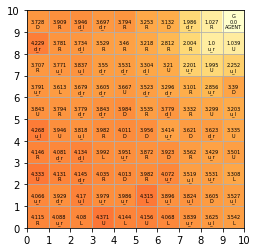

s:(8, 5) a:(9, 4) a':u_l
-----
s:(9, 4) a:(8, 5) a':L
-----
s:(8, 5) a:(7, 5) a':L
-----
s:(7, 5) a:(7, 5) a':L
-----
s:(7, 5) a:(6, 5) a':D
-----
s:(6, 5) a:(6, 4) a':D
-----
s:(6, 4) a:(6, 3) a':U
-----
s:(6, 3) a:(6, 4) a':u_l
-----
s:(6, 4) a:(5, 5) a':d_l
-----
s:(5, 5) a:(4, 4) a':R
-----
s:(4, 4) a:(4, 4) a':R
-----
s:(4, 4) a:(5, 4) a':L
-----
s:(5, 4) a:(4, 4) a':u_r
-----
s:(4, 4) a:(4, 4) a':u_r
-----
s:(4, 4) a:(5, 5) a':u_r
-----
s:(5, 5) a:(6, 6) a':u_r
-----
s:(6, 6) a:(7, 7) a':u_r
-----
s:(7, 7) a:(7, 7) a':u_r
-----
s:(7, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


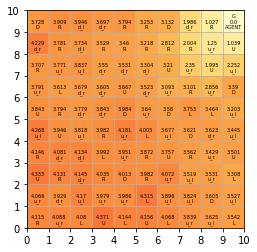

s:(5, 5) a:(6, 4) a':d_r
-----
s:(6, 4) a:(7, 3) a':U
-----
s:(7, 3) a:(7, 4) a':d_r
-----
s:(7, 4) a:(8, 3) a':d_r
-----
s:(8, 3) a:(9, 2) a':u_r
-----
s:(9, 2) a:(9, 2) a':u_r
-----
s:(9, 2) a:(9, 2) a':d_r
-----
s:(9, 2) a:(9, 2) a':d_r
-----
s:(9, 2) a:(9, 2) a':D
-----
s:(9, 2) a:(9, 1) a':U
-----
s:(9, 1) a:(9, 2) a':U
-----
s:(9, 2) a:(9, 3) a':L
-----
s:(9, 3) a:(8, 3) a':D
-----
s:(8, 3) a:(8, 2) a':U
-----
s:(8, 2) a:(8, 3) a':u_l
-----
s:(8, 3) a:(7, 4) a':R
-----
s:(7, 4) a:(8, 4) a':u_r
-----
s:(8, 4) a:(9, 5) a':D
-----
s:(9, 5) a:(9, 4) a':u_r
-----
s:(9, 4) a:(9, 4) a':u_r
-----
s:(9, 4) a:(9, 4) a':d_r
-----
s:(9, 4) a:(9, 4) a':d_r
-----
s:(9, 4) a:(9, 4) a':R
-----
s:(9, 4) a:(9, 4) a':R
-----
s:(9, 4) a:(9, 4) a':L
-----
s:(9, 4) a:(8, 4) a':U
-----
s:(8, 4) a:(8, 5) a':u_r
-----
s:(8, 5) a:(9, 6) a':U
-----
s:(9, 6) a:(9, 7) a':U
-----
s:(9, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


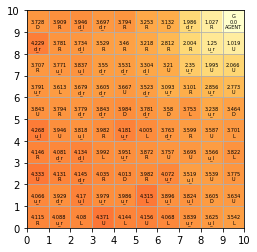

s:(8, 9) a:(9, 9) a':R
-----


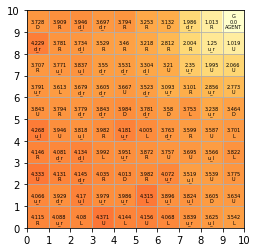

s:(4, 3) a:(4, 2) a':R
-----
s:(4, 2) a:(5, 2) a':u_r
-----
s:(5, 2) a:(5, 2) a':u_r
-----
s:(5, 2) a:(6, 3) a':u_l
-----
s:(6, 3) a:(5, 4) a':u_r
-----
s:(5, 4) a:(6, 5) a':u_r
-----
s:(6, 5) a:(7, 6) a':U
-----
s:(7, 6) a:(7, 7) a':u_r
-----
s:(7, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


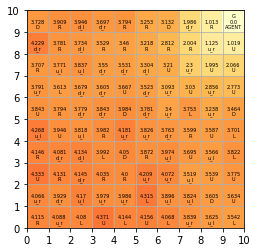

s:(9, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


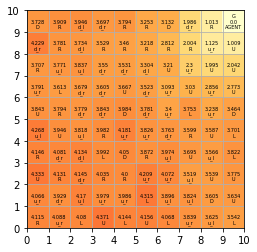

s:(8, 4) a:(8, 4) a':D
-----
s:(8, 4) a:(8, 3) a':U
-----
s:(8, 3) a:(8, 4) a':R
-----
s:(8, 4) a:(9, 4) a':D
-----
s:(9, 4) a:(9, 3) a':d_l
-----
s:(9, 3) a:(8, 2) a':d_l
-----
s:(8, 2) a:(7, 1) a':U
-----
s:(7, 1) a:(7, 2) a':D
-----
s:(7, 2) a:(7, 1) a':u_r
-----
s:(7, 1) a:(8, 2) a':R
-----
s:(8, 2) a:(9, 2) a':R
-----
s:(9, 2) a:(9, 2) a':R
-----
s:(9, 2) a:(9, 2) a':L
-----
s:(9, 2) a:(8, 2) a':L
-----
s:(8, 2) a:(7, 2) a':R
-----
s:(7, 2) a:(7, 2) a':R
-----
s:(7, 2) a:(8, 2) a':u_l
-----
s:(8, 2) a:(8, 2) a':u_l
-----
s:(8, 2) a:(7, 3) a':d_l
-----
s:(7, 3) a:(6, 2) a':d_r
-----
s:(6, 2) a:(7, 1) a':D
-----
s:(7, 1) a:(7, 0) a':D
-----
s:(7, 0) a:(7, 0) a':D
-----
s:(7, 0) a:(7, 0) a':U
-----
s:(7, 0) a:(7, 1) a':d_r
-----
s:(7, 1) a:(8, 0) a':U
-----
s:(8, 0) a:(8, 1) a':d_r
-----
s:(8, 1) a:(9, 0) a':D
-----
s:(9, 0) a:(9, 0) a':D
-----
s:(9, 0) a:(9, 0) a':U
-----
s:(9, 0) a:(9, 1) a':u_r
-----
s:(9, 1) a:(9, 1) a':u_r
-----
s:(9, 1) a:(9, 1) a':d_l
-----
s:(9, 1) a:(8, 0) a

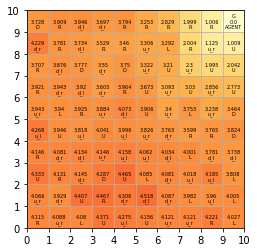

s:(7, 9) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


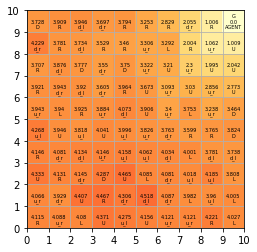

s:(4, 9) a:(4, 9) a':u_r
-----
s:(4, 9) a:(4, 9) a':L
-----
s:(4, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':d_l
-----
s:(3, 9) a:(2, 8) a':D
-----
s:(2, 8) a:(2, 7) a':U
-----
s:(2, 7) a:(2, 8) a':R
-----
s:(2, 8) a:(3, 8) a':L
-----
s:(3, 8) a:(2, 8) a':L
-----
s:(2, 8) a:(1, 8) a':d_r
-----
s:(1, 8) a:(2, 7) a':u_r
-----
s:(2, 7) a:(3, 8) a':D
-----
s:(3, 8) a:(3, 7) a':L
-----
s:(3, 7) a:(2, 7) a':D
-----
s:(2, 7) a:(2, 6) a':U
-----
s:(2, 6) a:(2, 7) a':L
-----
s:(2, 7) a:(1, 7) a':L
-----
s:(1, 7) a:(0, 7) a':L
-----
s:(0, 7) a:(0, 7) a':L
-----
s:(0, 7) a:(0, 7) a':d_r
-----
s:(0, 7) a:(0, 7) a':d_r
-----
s:(0, 7) a:(0, 7) a':U
-----
s:(0, 7) a:(0, 8) a':u_r
-----
s:(0, 8) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 8) a':u_l
-----
s:(1, 8) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':d_l
-----
s:(1, 9) a:(0, 8) a':U
-----
s:(0, 8) a:(0, 9) a':u_l
-----
s:(0, 9) a:(0, 9) a':u_l
-----
s:(0, 9) a:(0, 9) a':L
-----
s:(0, 9) a:(0, 9) a

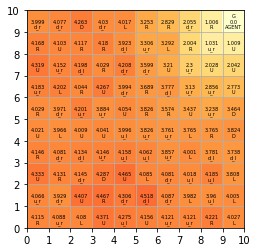

s:(3, 0) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':R
-----
s:(3, 0) a:(4, 0) a':U
-----
s:(4, 0) a:(4, 1) a':R
-----
s:(4, 1) a:(5, 1) a':U
-----
s:(5, 1) a:(5, 2) a':d_l
-----
s:(5, 2) a:(4, 1) a':L
-----
s:(4, 1) a:(3, 1) a':u_l
-----
s:(3, 1) a:(2, 2) a':L
-----
s:(2, 2) a:(1, 2) a':D
-----
s:(1, 2) a:(1, 1) a':R
-----
s:(1, 1) a:(2, 1) a':d_l
-----
s:(2, 1) a:(1, 0) a':u_l
-----
s:(1, 0) a:(0, 1) a':u_l
-----
s:(0, 1) a:(0, 1) a':d_r
-----
s:(0, 1) a:(1, 0) a':U
-----
s:(1, 0) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':D
-----
s:(0, 0) a:(0, 0) a':D
-----
s:(0, 0) a:(0, 0) a':L
-----
s:(0, 0) a:(0, 0) a':L
-----
s:(0, 0) a:(0, 0) a':u_r
-----
s:(0, 0) a:(1, 1) a':u_r
-----
s:(1, 1) a:(2, 2) a':d_l
-----
s:(2, 2) a:(1, 1) a':D
-----
s:(1, 1) a:(1, 0) a':d_l
-----
s:(1, 0) a:(1, 0) a':d_l
-----
s:(1, 0) a:(1, 0) a':d_r
-----
s:(1, 0) a:(1, 0) a':d_r
-----
s:(1, 0) a:(1, 0) a':D
-----
s:(1, 0) a:(1, 0) a':D
-----
s:(1, 0) a:(1, 0) a':U
-----
s:(1, 0) a:(1, 1) a':u_l
-----
s:(1, 1) a:

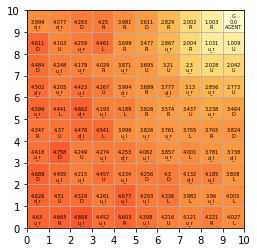

s:(7, 5) a:(8, 4) a':d_l
-----
s:(8, 4) a:(7, 3) a':D
-----
s:(7, 3) a:(7, 2) a':D
-----
s:(7, 2) a:(7, 1) a':d_l
-----
s:(7, 1) a:(6, 0) a':D
-----
s:(6, 0) a:(6, 0) a':D
-----
s:(6, 0) a:(6, 0) a':R
-----
s:(6, 0) a:(7, 0) a':u_l
-----
s:(7, 0) a:(6, 1) a':u_l
-----
s:(6, 1) a:(5, 2) a':U
-----
s:(5, 2) a:(5, 3) a':D
-----
s:(5, 3) a:(5, 2) a':R
-----
s:(5, 2) a:(6, 2) a':u_l
-----
s:(6, 2) a:(5, 3) a':u_r
-----
s:(5, 3) a:(5, 3) a':u_r
-----
s:(5, 3) a:(6, 4) a':d_l
-----
s:(6, 4) a:(5, 3) a':d_l
-----
s:(5, 3) a:(4, 2) a':L
-----
s:(4, 2) a:(3, 2) a':R
-----
s:(3, 2) a:(3, 2) a':R
-----
s:(3, 2) a:(4, 2) a':R
-----
s:(4, 2) a:(4, 2) a':R
-----
s:(4, 2) a:(5, 2) a':L
-----
s:(5, 2) a:(4, 2) a':D
-----
s:(4, 2) a:(4, 1) a':U
-----
s:(4, 1) a:(4, 2) a':d_l
-----
s:(4, 2) a:(3, 1) a':u_r
-----
s:(3, 1) a:(4, 2) a':u_l
-----
s:(4, 2) a:(3, 3) a':U
-----
s:(3, 3) a:(3, 3) a':U
-----
s:(3, 3) a:(3, 3) a':R
-----
s:(3, 3) a:(4, 3) a':d_l
-----
s:(4, 3) a:(3, 2) a':U
-----
s:(3, 2) a:(3, 3)

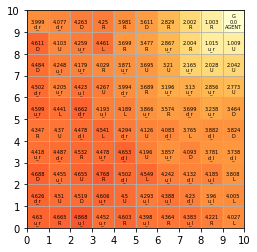

s:(3, 1) a:(4, 0) a':D
-----
s:(4, 0) a:(4, 0) a':D
-----
s:(4, 0) a:(4, 0) a':d_r
-----
s:(4, 0) a:(4, 0) a':d_r
-----
s:(4, 0) a:(4, 0) a':u_r
-----
s:(4, 0) a:(5, 1) a':u_l
-----
s:(5, 1) a:(4, 2) a':d_r
-----
s:(4, 2) a:(5, 1) a':u_r
-----
s:(5, 1) a:(6, 2) a':U
-----
s:(6, 2) a:(6, 3) a':L
-----
s:(6, 3) a:(5, 3) a':L
-----
s:(5, 3) a:(4, 3) a':u_l
-----
s:(4, 3) a:(3, 4) a':d_r
-----
s:(3, 4) a:(4, 3) a':R
-----
s:(4, 3) a:(5, 3) a':R
-----
s:(5, 3) a:(5, 3) a':R
-----
s:(5, 3) a:(6, 3) a':R
-----
s:(6, 3) a:(7, 3) a':u_r
-----
s:(7, 3) a:(8, 4) a':L
-----
s:(8, 4) a:(8, 4) a':L
-----
s:(8, 4) a:(7, 4) a':u_r
-----
s:(7, 4) a:(8, 5) a':u_l
-----
s:(8, 5) a:(7, 6) a':d_l
-----
s:(7, 6) a:(6, 5) a':U
-----
s:(6, 5) a:(6, 6) a':L
-----
s:(6, 6) a:(5, 6) a':u_r
-----
s:(5, 6) a:(5, 6) a':u_r
-----
s:(5, 6) a:(6, 7) a':R
-----
s:(6, 7) a:(7, 7) a':u_r
-----
s:(7, 7) a:(7, 7) a':u_r
-----
s:(7, 7) a:(7, 7) a':d_l
-----
s:(7, 7) a:(6, 6) a':u_r
-----
s:(6, 6) a:(7, 7) a':D
-----
s:(7, 7

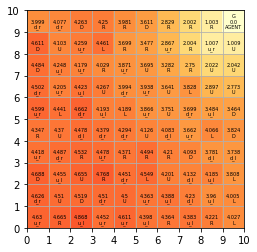

s:(3, 4) a:(4, 4) a':L
-----
s:(4, 4) a:(3, 4) a':u_l
-----
s:(3, 4) a:(2, 5) a':D
-----
s:(2, 5) a:(2, 4) a':L
-----
s:(2, 4) a:(2, 4) a':L
-----
s:(2, 4) a:(1, 4) a':R
-----
s:(1, 4) a:(2, 4) a':U
-----
s:(2, 4) a:(2, 5) a':L
-----
s:(2, 5) a:(1, 5) a':d_r
-----
s:(1, 5) a:(2, 4) a':u_r
-----
s:(2, 4) a:(2, 4) a':u_r
-----
s:(2, 4) a:(3, 5) a':U
-----
s:(3, 5) a:(3, 6) a':D
-----
s:(3, 6) a:(3, 5) a':d_r
-----
s:(3, 5) a:(4, 4) a':U
-----
s:(4, 4) a:(4, 5) a':d_r
-----
s:(4, 5) a:(5, 4) a':d_l
-----
s:(5, 4) a:(4, 3) a':L
-----
s:(4, 3) a:(3, 3) a':d_r
-----
s:(3, 3) a:(4, 2) a':u_r
-----
s:(4, 2) a:(5, 3) a':d_r
-----
s:(5, 3) a:(6, 2) a':R
-----
s:(6, 2) a:(7, 2) a':u_r
-----
s:(7, 2) a:(8, 3) a':R
-----
s:(8, 3) a:(9, 3) a':d_r
-----
s:(9, 3) a:(9, 3) a':u_l
-----
s:(9, 3) a:(8, 4) a':u_r
-----
s:(8, 4) a:(9, 5) a':U
-----
s:(9, 5) a:(9, 6) a':R
-----
s:(9, 6) a:(9, 6) a':R
-----
s:(9, 6) a:(9, 6) a':d_r
-----
s:(9, 6) a:(9, 6) a':d_r
-----
s:(9, 6) a:(9, 6) a':u_r
-----
s:(9, 6) 

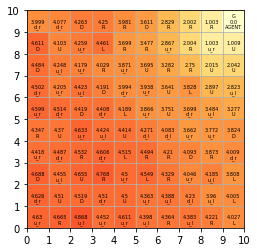

s:(0, 8) a:(0, 8) a':d_r
-----
s:(0, 8) a:(1, 7) a':L
-----
s:(1, 7) a:(0, 7) a':u_r
-----
s:(0, 7) a:(1, 8) a':L
-----
s:(1, 8) a:(0, 8) a':u_r
-----
s:(0, 8) a:(1, 9) a':L
-----
s:(1, 9) a:(1, 9) a':L
-----
s:(1, 9) a:(0, 9) a':d_l
-----
s:(0, 9) a:(0, 9) a':d_l
-----
s:(0, 9) a:(0, 9) a':D
-----
s:(0, 9) a:(0, 8) a':d_l
-----
s:(0, 8) a:(0, 8) a':U
-----
s:(0, 8) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':U
-----
s:(0, 9) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':u_r
-----
s:(1, 9) a:(1, 9) a':u_r
-----
s:(1, 9) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 8) a':R
-----
s:(1, 8) a:(2, 8) a':d_l
-----
s:(2, 8) a:(1, 7) a':L
-----
s:(1, 7) a:(0, 7) a':d_r
-----
s:(0, 7) a:(1, 6) a':d_r
-----
s:(1, 6) a:(2, 5) a':u_l
-----
s:(2, 5) a:(1, 6) a':d_l
-----
s:(1, 6) a:(0, 5) a':R
-----
s:(0, 5) a:(0, 5) a':R
-----
s:(0, 5) a:(1, 5) a':U
-----
s:(1, 5) a:(1, 6) a':R
-----
s:(1, 6) a:(2, 6) a':U
-----
s:(2, 6) a:(2, 6) a':U
-----
s:(2, 6) a:(2, 7) a':R
-----
s:(2, 7) a:(3, 7) a':d_r
-----
s:(3, 7) a:(4, 

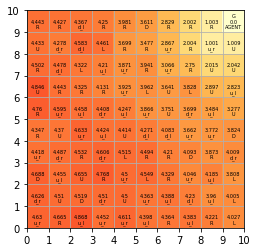

s:(1, 6) a:(1, 6) a':D
-----
s:(1, 6) a:(1, 5) a':D
-----
s:(1, 5) a:(1, 4) a':L
-----
s:(1, 4) a:(0, 4) a':L
-----
s:(0, 4) a:(0, 4) a':L
-----
s:(0, 4) a:(0, 4) a':U
-----
s:(0, 4) a:(0, 5) a':d_l
-----
s:(0, 5) a:(0, 5) a':u_r
-----
s:(0, 5) a:(1, 6) a':L
-----
s:(1, 6) a:(1, 6) a':U
-----
s:(1, 6) a:(1, 7) a':R
-----
s:(1, 7) a:(2, 7) a':d_r
-----
s:(2, 7) a:(3, 6) a':u_r
-----
s:(3, 6) a:(4, 7) a':R
-----
s:(4, 7) a:(5, 7) a':d_l
-----
s:(5, 7) a:(4, 6) a':d_l
-----
s:(4, 6) a:(4, 6) a':d_l
-----
s:(4, 6) a:(3, 5) a':u_r
-----
s:(3, 5) a:(4, 6) a':U
-----
s:(4, 6) a:(4, 7) a':u_l
-----
s:(4, 7) a:(3, 8) a':D
-----
s:(3, 8) a:(3, 7) a':D
-----
s:(3, 7) a:(3, 6) a':u_l
-----
s:(3, 6) a:(2, 7) a':u_l
-----
s:(2, 7) a:(1, 8) a':R
-----
s:(1, 8) a:(2, 8) a':L
-----
s:(2, 8) a:(1, 8) a':d_l
-----
s:(1, 8) a:(0, 7) a':U
-----
s:(0, 7) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':R
-----
s:(0, 8) a:(1, 8) a':u_l
-----
s:(1, 8) a:(0, 9) a':d_r
-----
s:(0, 9) a:(0, 

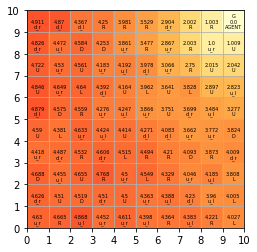

s:(5, 4) a:(6, 3) a':U
-----
s:(6, 3) a:(6, 4) a':R
-----
s:(6, 4) a:(7, 4) a':U
-----
s:(7, 4) a:(7, 5) a':u_l
-----
s:(7, 5) a:(7, 5) a':u_l
-----
s:(7, 5) a:(6, 6) a':d_r
-----
s:(6, 6) a:(7, 5) a':u_r
-----
s:(7, 5) a:(8, 6) a':L
-----
s:(8, 6) a:(7, 6) a':D
-----
s:(7, 6) a:(7, 5) a':R
-----
s:(7, 5) a:(8, 5) a':R
-----
s:(8, 5) a:(9, 5) a':u_l
-----
s:(9, 5) a:(8, 6) a':d_r
-----
s:(8, 6) a:(9, 5) a':d_l
-----
s:(9, 5) a:(8, 4) a':u_l
-----
s:(8, 4) a:(7, 5) a':d_l
-----
s:(7, 5) a:(6, 4) a':d_r
-----
s:(6, 4) a:(7, 3) a':R
-----
s:(7, 3) a:(8, 3) a':d_r
-----
s:(8, 3) a:(9, 2) a':u_l
-----
s:(9, 2) a:(8, 3) a':u_r
-----
s:(8, 3) a:(9, 4) a':u_r
-----
s:(9, 4) a:(9, 4) a':U
-----
s:(9, 4) a:(9, 5) a':D
-----
s:(9, 5) a:(9, 4) a':d_l
-----
s:(9, 4) a:(8, 3) a':L
-----
s:(8, 3) a:(7, 3) a':d_r
-----
s:(7, 3) a:(8, 2) a':D
-----
s:(8, 2) a:(8, 1) a':u_r
-----
s:(8, 1) a:(9, 2) a':d_l
-----
s:(9, 2) a:(8, 1) a':L
-----
s:(8, 1) a:(7, 1) a':D
-----
s:(7, 1) a:(7, 0) a':U
-----
s:(7, 0

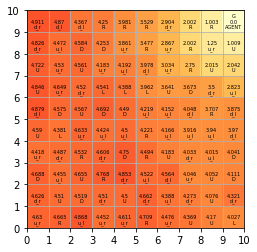

s:(5, 3) a:(4, 4) a':D
-----
s:(4, 4) a:(4, 3) a':U
-----
s:(4, 3) a:(4, 4) a':u_r
-----
s:(4, 4) a:(4, 4) a':d_l
-----
s:(4, 4) a:(4, 4) a':d_l
-----
s:(4, 4) a:(3, 3) a':d_l
-----
s:(3, 3) a:(2, 2) a':D
-----
s:(2, 2) a:(2, 1) a':d_r
-----
s:(2, 1) a:(3, 0) a':L
-----
s:(3, 0) a:(2, 0) a':U
-----
s:(2, 0) a:(2, 1) a':R
-----
s:(2, 1) a:(3, 1) a':u_l
-----
s:(3, 1) a:(2, 2) a':d_r
-----
s:(2, 2) a:(3, 1) a':U
-----
s:(3, 1) a:(3, 2) a':d_l
-----
s:(3, 2) a:(2, 1) a':L
-----
s:(2, 1) a:(1, 1) a':U
-----
s:(1, 1) a:(1, 2) a':D
-----
s:(1, 2) a:(1, 1) a':d_r
-----
s:(1, 1) a:(1, 1) a':u_r
-----
s:(1, 1) a:(2, 2) a':d_l
-----
s:(2, 2) a:(1, 1) a':d_l
-----
s:(1, 1) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':u_l
-----
s:(0, 0) a:(0, 0) a':u_l
-----
s:(0, 0) a:(0, 0) a':D
-----
s:(0, 0) a:(0, 0) a':D
-----
s:(0, 0) a:(0, 0) a':R
-----
s:(0, 0) a:(1, 0) a':u_l
-----
s:(1, 0) a:(0, 1) a':d_l
-----
s:(0, 1) a:(0, 1) a':d_l
-----
s:(0, 1) a:(0, 1) a':u_l
-----
s:(0, 1) a:(0, 1) a':u_l
-----
s:(

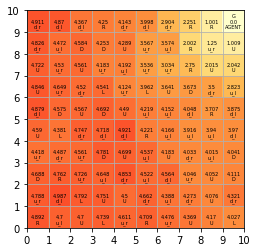

s:(9, 7) a:(9, 7) a':U
-----
s:(9, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


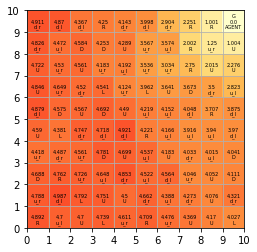

s:(0, 5) a:(0, 4) a':u_r
-----
s:(0, 4) a:(1, 5) a':d_l
-----
s:(1, 5) a:(0, 4) a':d_l
-----
s:(0, 4) a:(0, 4) a':d_l
-----
s:(0, 4) a:(0, 4) a':D
-----
s:(0, 4) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':u_l
-----
s:(0, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':u_r
-----
s:(0, 2) a:(1, 3) a':U
-----
s:(1, 3) a:(1, 4) a':u_r
-----
s:(1, 4) a:(2, 5) a':u_r
-----
s:(2, 5) a:(3, 6) a':R
-----
s:(3, 6) a:(4, 6) a':R
-----
s:(4, 6) a:(5, 6) a':d_l
-----
s:(5, 6) a:(4, 5) a':d_l
-----
s:(4, 5) a:(3, 4) a':U
-----
s:(3, 4) a:(3, 5) a':L
-----
s:(3, 5) a:(2, 5) a':d_l
-----
s:(2, 5) a:(1, 4) a':d_l
-----
s:(1, 4) a:(1, 4) a':d_l
-----
s:(1, 4) a:(0, 3) a':U
-----
s:(0, 3) a:(0, 3) a':U
-----
s:(0, 3) a:(0, 4) a':u_l
-----
s:(0, 4) a:(0, 4) a':u_l
-----
s:(0, 4) a:(0, 4) a':d_r
-----
s:(0, 4) a:(1, 3) a':R
-----
s:(1, 3) a:(2, 3) a':d_l
-----
s:(2, 3) a:(1, 2) a':d_r
-----
s:(1, 2) a:(2, 1) a':u_r
-----
s:(2, 1) a:(3, 2) a':D
-----
s:(3, 2) a:(3, 1) a':D
-----
s:(3, 1) a:(3, 0) a':U
-----
s:(

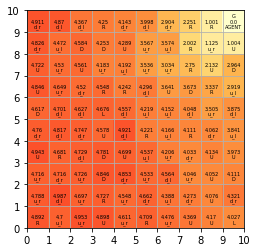

s:(9, 4) a:(9, 4) a':D
-----
s:(9, 4) a:(9, 3) a':d_l
-----
s:(9, 3) a:(8, 2) a':d_l
-----
s:(8, 2) a:(7, 1) a':U
-----
s:(7, 1) a:(7, 2) a':U
-----
s:(7, 2) a:(7, 3) a':U
-----
s:(7, 3) a:(7, 4) a':D
-----
s:(7, 4) a:(7, 3) a':u_r
-----
s:(7, 3) a:(8, 4) a':R
-----
s:(8, 4) a:(9, 4) a':u_l
-----
s:(9, 4) a:(8, 5) a':U
-----
s:(8, 5) a:(8, 6) a':u_r
-----
s:(8, 6) a:(9, 7) a':L
-----
s:(9, 7) a:(8, 7) a':D
-----
s:(8, 7) a:(8, 7) a':D
-----
s:(8, 7) a:(8, 6) a':U
-----
s:(8, 6) a:(8, 6) a':U
-----
s:(8, 6) a:(8, 7) a':L
-----
s:(8, 7) a:(7, 7) a':d_r
-----
s:(7, 7) a:(8, 6) a':u_l
-----
s:(8, 6) a:(7, 7) a':U
-----
s:(7, 7) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


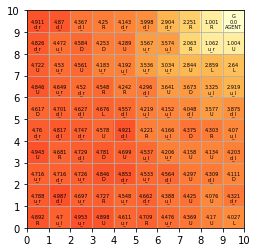

s:(6, 7) a:(7, 8) a':u_r
-----
s:(7, 8) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


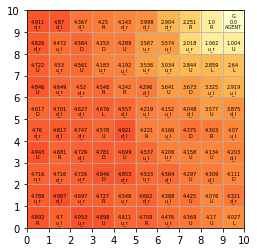

s:(7, 1) a:(6, 1) a':u_r
-----
s:(6, 1) a:(7, 2) a':d_r
-----
s:(7, 2) a:(8, 1) a':R
-----
s:(8, 1) a:(9, 1) a':U
-----
s:(9, 1) a:(9, 2) a':u_r
-----
s:(9, 2) a:(9, 2) a':u_r
-----
s:(9, 2) a:(9, 2) a':d_r
-----
s:(9, 2) a:(9, 2) a':d_r
-----
s:(9, 2) a:(9, 2) a':d_r
-----
s:(9, 2) a:(9, 2) a':U
-----
s:(9, 2) a:(9, 3) a':L
-----
s:(9, 3) a:(8, 3) a':D
-----
s:(8, 3) a:(8, 2) a':L
-----
s:(8, 2) a:(7, 2) a':L
-----
s:(7, 2) a:(6, 2) a':u_r
-----
s:(6, 2) a:(7, 3) a':R
-----
s:(7, 3) a:(8, 3) a':d_l
-----
s:(8, 3) a:(7, 2) a':R
-----
s:(7, 2) a:(8, 2) a':R
-----
s:(8, 2) a:(9, 2) a':L
-----
s:(9, 2) a:(8, 2) a':D
-----
s:(8, 2) a:(8, 1) a':d_l
-----
s:(8, 1) a:(7, 0) a':R
-----
s:(7, 0) a:(7, 0) a':R
-----
s:(7, 0) a:(8, 0) a':d_l
-----
s:(8, 0) a:(8, 0) a':d_r
-----
s:(8, 0) a:(8, 0) a':d_r
-----
s:(8, 0) a:(8, 0) a':U
-----
s:(8, 0) a:(8, 1) a':u_r
-----
s:(8, 1) a:(9, 2) a':u_l
-----
s:(9, 2) a:(8, 3) a':R
-----
s:(8, 3) a:(9, 3) a':L
-----
s:(9, 3) a:(8, 3) a':d_r
-----
s:(8, 3) a:

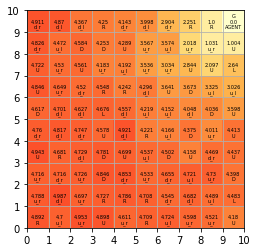

s:(7, 0) a:(6, 0) a':U
-----
s:(6, 0) a:(6, 1) a':D
-----
s:(6, 1) a:(6, 0) a':d_l
-----
s:(6, 0) a:(6, 0) a':d_l
-----
s:(6, 0) a:(6, 0) a':R
-----
s:(6, 0) a:(7, 0) a':d_l
-----
s:(7, 0) a:(7, 0) a':d_l
-----
s:(7, 0) a:(7, 0) a':U
-----
s:(7, 0) a:(7, 1) a':R
-----
s:(7, 1) a:(8, 1) a':d_r
-----
s:(8, 1) a:(9, 0) a':d_l
-----
s:(9, 0) a:(9, 0) a':d_l
-----
s:(9, 0) a:(9, 0) a':d_r
-----
s:(9, 0) a:(9, 0) a':d_r
-----
s:(9, 0) a:(9, 0) a':u_l
-----
s:(9, 0) a:(8, 1) a':D
-----
s:(8, 1) a:(8, 0) a':L
-----
s:(8, 0) a:(7, 0) a':u_l
-----
s:(7, 0) a:(6, 1) a':R
-----
s:(6, 1) a:(7, 1) a':d_r
-----
s:(7, 1) a:(7, 1) a':d_r
-----
s:(7, 1) a:(8, 0) a':R
-----
s:(8, 0) a:(9, 0) a':D
-----
s:(9, 0) a:(9, 0) a':D
-----
s:(9, 0) a:(9, 0) a':R
-----
s:(9, 0) a:(9, 0) a':R
-----
s:(9, 0) a:(9, 0) a':L
-----
s:(9, 0) a:(8, 0) a':D
-----
s:(8, 0) a:(8, 0) a':D
-----
s:(8, 0) a:(8, 0) a':u_l
-----
s:(8, 0) a:(7, 1) a':d_r
-----
s:(7, 1) a:(8, 0) a':d_l
-----
s:(8, 0) a:(8, 0) a':d_l
-----
s:(8, 0) 

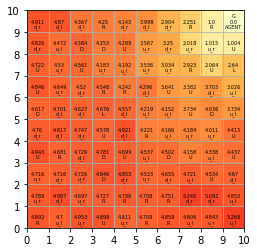

s:(8, 5) a:(9, 4) a':d_r
-----
s:(9, 4) a:(9, 4) a':d_r
-----
s:(9, 4) a:(9, 4) a':d_l
-----
s:(9, 4) a:(8, 3) a':L
-----
s:(8, 3) a:(7, 3) a':u_l
-----
s:(7, 3) a:(6, 4) a':D
-----
s:(6, 4) a:(6, 3) a':u_l
-----
s:(6, 3) a:(5, 4) a':u_r
-----
s:(5, 4) a:(5, 4) a':u_r
-----
s:(5, 4) a:(6, 5) a':u_r
-----
s:(6, 5) a:(7, 6) a':u_l
-----
s:(7, 6) a:(6, 7) a':u_r
-----
s:(6, 7) a:(7, 8) a':u_r
-----
s:(7, 8) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


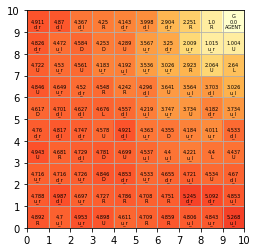

s:(2, 2) a:(1, 2) a':L
-----
s:(1, 2) a:(0, 2) a':u_l
-----
s:(0, 2) a:(0, 2) a':d_r
-----
s:(0, 2) a:(1, 1) a':u_l
-----
s:(1, 1) a:(0, 2) a':U
-----
s:(0, 2) a:(0, 3) a':R
-----
s:(0, 3) a:(1, 3) a':d_l
-----
s:(1, 3) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':d_l
-----
s:(0, 2) a:(0, 2) a':R
-----
s:(0, 2) a:(1, 2) a':u_r
-----
s:(1, 2) a:(2, 3) a':d_r
-----
s:(2, 3) a:(3, 2) a':u_r
-----
s:(3, 2) a:(4, 3) a':d_r
-----
s:(4, 3) a:(5, 2) a':d_l
-----
s:(5, 2) a:(4, 1) a':d_l
-----
s:(4, 1) a:(4, 1) a':d_l
-----
s:(4, 1) a:(3, 0) a':u_l
-----
s:(3, 0) a:(3, 0) a':u_l
-----
s:(3, 0) a:(2, 1) a':u_l
-----
s:(2, 1) a:(1, 2) a':d_r
-----
s:(1, 2) a:(2, 1) a':d_l
-----
s:(2, 1) a:(1, 0) a':U
-----
s:(1, 0) a:(1, 1) a':R
-----
s:(1, 1) a:(2, 1) a':U
-----
s:(2, 1) a:(2, 2) a':D
-----
s:(2, 2) a:(2, 1) a':D
-----
s:(2, 1) a:(2, 0) a':R
-----
s:(2, 0) a:(3, 0) a':R
-----
s:(3, 0) a:(4, 0) a':d_l
-----
s:(4, 0) a:(4, 0) a':d_l
-----
s:(4, 0) a:(4, 0) a':R
-----
s:(4, 0) a:(5, 0) a':u_r
-----
s

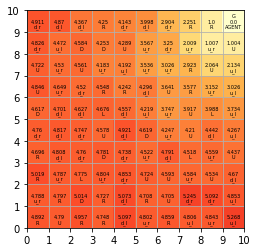

s:(2, 9) a:(2, 9) a':d_r
-----
s:(2, 9) a:(3, 8) a':d_r
-----
s:(3, 8) a:(4, 7) a':U
-----
s:(4, 7) a:(4, 8) a':R
-----
s:(4, 8) a:(5, 8) a':L
-----
s:(5, 8) a:(5, 8) a':L
-----
s:(5, 8) a:(4, 8) a':d_r
-----
s:(4, 8) a:(5, 7) a':u_r
-----
s:(5, 7) a:(6, 8) a':R
-----
s:(6, 8) a:(6, 8) a':R
-----
s:(6, 8) a:(7, 8) a':u_r
-----
s:(7, 8) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


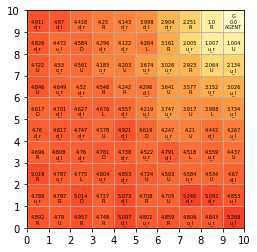

s:(0, 0) a:(0, 1) a':R
-----
s:(0, 1) a:(1, 1) a':R
-----
s:(1, 1) a:(2, 1) a':d_r
-----
s:(2, 1) a:(3, 0) a':u_r
-----
s:(3, 0) a:(4, 1) a':d_r
-----
s:(4, 1) a:(5, 0) a':u_l
-----
s:(5, 0) a:(4, 1) a':L
-----
s:(4, 1) a:(3, 1) a':d_r
-----
s:(3, 1) a:(3, 1) a':d_r
-----
s:(3, 1) a:(4, 0) a':L
-----
s:(4, 0) a:(3, 0) a':D
-----
s:(3, 0) a:(3, 0) a':D
-----
s:(3, 0) a:(3, 0) a':d_l
-----
s:(3, 0) a:(3, 0) a':d_l
-----
s:(3, 0) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':d_r
-----
s:(3, 0) a:(3, 0) a':L
-----
s:(3, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':D
-----
s:(2, 0) a:(2, 0) a':L
-----
s:(2, 0) a:(1, 0) a':u_r
-----
s:(1, 0) a:(2, 1) a':R
-----
s:(2, 1) a:(3, 1) a':L
-----
s:(3, 1) a:(2, 1) a':u_r
-----
s:(2, 1) a:(3, 2) a':d_l
-----
s:(3, 2) a:(2, 1) a':L
-----
s:(2, 1) a:(1, 1) a':D
-----
s:(1, 1) a:(1, 0) a':d_l
-----
s:(1, 0) a:(1, 0) a':d_l
-----
s:(1, 0) a:(1, 0) a':L
-----
s:(1,

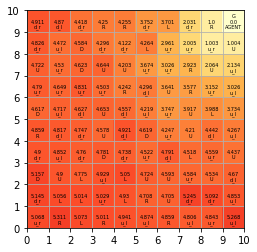

s:(6, 2) a:(5, 3) a':d_l
-----
s:(5, 3) a:(4, 2) a':U
-----
s:(4, 2) a:(4, 3) a':u_r
-----
s:(4, 3) a:(5, 4) a':L
-----
s:(5, 4) a:(4, 4) a':R
-----
s:(4, 4) a:(5, 4) a':u_l
-----
s:(5, 4) a:(4, 5) a':u_r
-----
s:(4, 5) a:(5, 6) a':d_r
-----
s:(5, 6) a:(6, 5) a':L
-----
s:(6, 5) a:(5, 5) a':D
-----
s:(5, 5) a:(5, 5) a':D
-----
s:(5, 5) a:(5, 4) a':U
-----
s:(5, 4) a:(5, 5) a':d_r
-----
s:(5, 5) a:(6, 4) a':L
-----
s:(6, 4) a:(6, 4) a':L
-----
s:(6, 4) a:(5, 4) a':R
-----
s:(5, 4) a:(6, 4) a':R
-----
s:(6, 4) a:(7, 4) a':L
-----
s:(7, 4) a:(6, 4) a':U
-----
s:(6, 4) a:(6, 5) a':R
-----
s:(6, 5) a:(7, 5) a':L
-----
s:(7, 5) a:(7, 5) a':L
-----
s:(7, 5) a:(6, 5) a':d_r
-----
s:(6, 5) a:(7, 4) a':d_l
-----
s:(7, 4) a:(6, 3) a':U
-----
s:(6, 3) a:(6, 4) a':d_l
-----
s:(6, 4) a:(5, 3) a':D
-----
s:(5, 3) a:(5, 2) a':D
-----
s:(5, 2) a:(5, 2) a':D
-----
s:(5, 2) a:(5, 1) a':R
-----
s:(5, 1) a:(6, 1) a':d_l
-----
s:(6, 1) a:(5, 0) a':D
-----
s:(5, 0) a:(5, 0) a':D
-----
s:(5, 0) a:(5, 0) a':d_

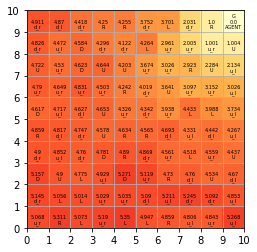

s:(1, 8) a:(2, 9) a':u_r
-----
s:(2, 9) a:(2, 9) a':u_r
-----
s:(2, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':d_r
-----
s:(1, 9) a:(2, 8) a':R
-----
s:(2, 8) a:(3, 8) a':U
-----
s:(3, 8) a:(3, 9) a':d_l
-----
s:(3, 9) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':u_l
-----
s:(2, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 8) a':u_r
-----
s:(2, 8) a:(3, 9) a':u_l
-----
s:(3, 9) a:(3, 9) a':u_l
-----
s:(3, 9) a:(3, 9) a':D
-----
s:(3, 9) a:(3, 8) a':u_l
-----
s:(3, 8) a:(2, 9) a':R
-----
s:(2, 9) a:(3, 9) a':d_r
-----
s:(3, 9) a:(4, 8) a':D
-----
s:(4, 8) a:(4, 7) a':D
-----
s:(4, 7) a:(4, 6) a':d_r
-----
s:(4, 6) a:(5, 5) a':R
-----
s:(5, 5) a:(6, 5) a':U
-----
s:(6, 5) a:(6, 6) a':R
-----
s:(6, 6) a:(7, 6) a':u_r
-----
s:(7, 6) a:(8, 7) a':U
-----
s:(8, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


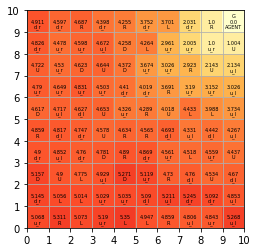

s:(9, 7) a:(9, 7) a':u_l
-----
s:(9, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':D
-----


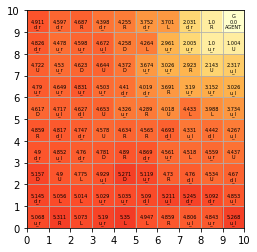

s:(5, 9) a:(6, 9) a':d_r
-----
s:(6, 9) a:(7, 8) a':u_r
-----
s:(7, 8) a:(7, 8) a':u_r
-----
s:(7, 8) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


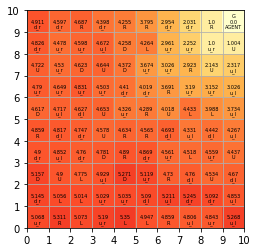

s:(8, 0) a:(8, 1) a':L
-----
s:(8, 1) a:(7, 1) a':D
-----
s:(7, 1) a:(7, 0) a':d_r
-----
s:(7, 0) a:(7, 0) a':d_r
-----
s:(7, 0) a:(7, 0) a':u_r
-----
s:(7, 0) a:(8, 1) a':u_l
-----
s:(8, 1) a:(8, 1) a':u_r
-----
s:(8, 1) a:(9, 2) a':U
-----
s:(9, 2) a:(9, 3) a':d_r
-----
s:(9, 3) a:(9, 3) a':d_r
-----
s:(9, 3) a:(9, 3) a':D
-----
s:(9, 3) a:(9, 2) a':L
-----
s:(9, 2) a:(8, 2) a':u_l
-----
s:(8, 2) a:(7, 3) a':d_r
-----
s:(7, 3) a:(8, 2) a':R
-----
s:(8, 2) a:(8, 2) a':R
-----
s:(8, 2) a:(9, 2) a':u_l
-----
s:(9, 2) a:(8, 3) a':U
-----
s:(8, 3) a:(8, 4) a':U
-----
s:(8, 4) a:(8, 4) a':U
-----
s:(8, 4) a:(8, 5) a':u_l
-----
s:(8, 5) a:(7, 6) a':d_r
-----
s:(7, 6) a:(8, 5) a':u_r
-----
s:(8, 5) a:(9, 6) a':U
-----
s:(9, 6) a:(9, 7) a':U
-----
s:(9, 7) a:(9, 7) a':U
-----
s:(9, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


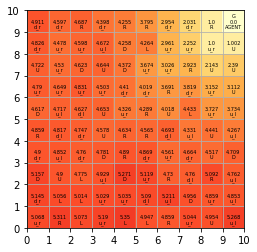

s:(7, 8) a:(7, 9) a':d_r
-----
s:(7, 9) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


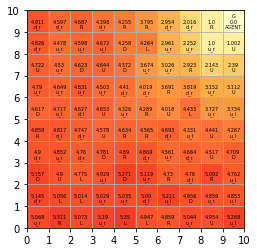

s:(0, 9) a:(0, 9) a':u_l
-----
s:(0, 9) a:(0, 9) a':L
-----
s:(0, 9) a:(0, 9) a':L
-----
s:(0, 9) a:(0, 9) a':u_r
-----
s:(0, 9) a:(0, 9) a':u_r
-----
s:(0, 9) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':D
-----
s:(1, 9) a:(1, 8) a':R
-----
s:(1, 8) a:(2, 8) a':U
-----
s:(2, 8) a:(2, 9) a':d_l
-----
s:(2, 9) a:(1, 8) a':U
-----
s:(1, 8) a:(1, 9) a':R
-----
s:(1, 9) a:(1, 9) a':R
-----
s:(1, 9) a:(2, 9) a':d_r
-----
s:(2, 9) a:(3, 8) a':d_l
-----
s:(3, 8) a:(2, 7) a':u_r
-----
s:(2, 7) a:(3, 8) a':R
-----
s:(3, 8) a:(4, 8) a':u_r
-----
s:(4, 8) a:(5, 9) a':d_r
-----
s:(5, 9) a:(6, 8) a':u_r
-----
s:(6, 8) a:(7, 9) a':d_r
-----
s:(7, 9) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


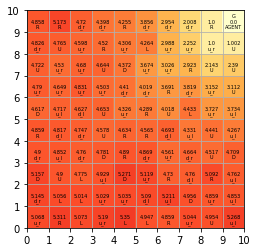

s:(0, 7) a:(1, 8) a':d_r
-----
s:(1, 8) a:(2, 7) a':d_l
-----
s:(2, 7) a:(1, 6) a':u_l
-----
s:(1, 6) a:(0, 7) a':u_l
-----
s:(0, 7) a:(0, 7) a':u_l
-----
s:(0, 7) a:(0, 7) a':D
-----
s:(0, 7) a:(0, 7) a':D
-----
s:(0, 7) a:(0, 6) a':R
-----
s:(0, 6) a:(1, 6) a':d_r
-----
s:(1, 6) a:(2, 5) a':D
-----
s:(2, 5) a:(2, 4) a':u_l
-----
s:(2, 4) a:(1, 5) a':d_l
-----
s:(1, 5) a:(0, 4) a':U
-----
s:(0, 4) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':d_r
-----
s:(0, 5) a:(0, 5) a':d_r
-----
s:(0, 5) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':D
-----
s:(0, 6) a:(0, 5) a':D
-----
s:(0, 5) a:(0, 4) a':D
-----
s:(0, 4) a:(0, 3) a':u_r
-----
s:(0, 3) a:(1, 4) a':d_r
-----
s:(1, 4) a:(2, 3) a':U
-----
s:(2, 3) a:(2, 4) a':D
-----
s:(2, 4) a:(2, 3) a':u_l
-----
s:(2, 3) a:(1, 4) a':D
-----
s:(1, 4) a:(1, 3) a':u_r
-----
s:(1, 3) a:(1, 3) a':u_r
-----
s:(1, 3) a:(2, 4) a':R
-----
s:(2, 4) a:(3, 4) a':D
-----
s:(3, 4) a:(3, 3) a':d_l
-----
s:(3, 3

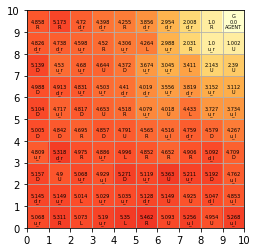

s:(0, 4) a:(1, 5) a':R
-----
s:(1, 5) a:(2, 5) a':u_l
-----
s:(2, 5) a:(1, 6) a':R
-----
s:(1, 6) a:(1, 6) a':R
-----
s:(1, 6) a:(2, 6) a':R
-----
s:(2, 6) a:(3, 6) a':D
-----
s:(3, 6) a:(3, 5) a':d_l
-----
s:(3, 5) a:(3, 5) a':d_l
-----
s:(3, 5) a:(2, 4) a':d_l
-----
s:(2, 4) a:(1, 3) a':R
-----
s:(1, 3) a:(1, 3) a':R
-----
s:(1, 3) a:(2, 3) a':u_r
-----
s:(2, 3) a:(3, 4) a':u_l
-----
s:(3, 4) a:(2, 5) a':u_l
-----
s:(2, 5) a:(1, 6) a':d_l
-----
s:(1, 6) a:(0, 5) a':R
-----
s:(0, 5) a:(1, 5) a':d_l
-----
s:(1, 5) a:(0, 4) a':L
-----
s:(0, 4) a:(0, 4) a':L
-----
s:(0, 4) a:(0, 4) a':d_r
-----
s:(0, 4) a:(1, 3) a':D
-----
s:(1, 3) a:(1, 2) a':u_l
-----
s:(1, 2) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':L
-----
s:(0, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':u_r
-----
s:(0, 2) a:(1, 3) a':L
-----
s:(1, 3) a:(0, 3) a':D
-----
s:(0, 3) a:(0, 2) a':d_r
-----
s:(0, 2) a:(1, 1) a':u_l
-----
s:(1, 1) a:(0, 2) a':U
-----
s:(0, 2) a:(0, 3) a':R
-----
s:(0, 3) a:(0, 3) a':R
-----
s:(0, 3) a:(1, 

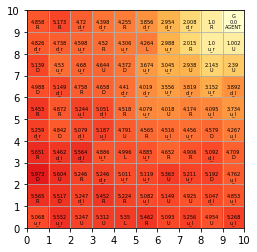

s:(5, 9) a:(5, 9) a':U
-----
s:(5, 9) a:(5, 9) a':R
-----
s:(5, 9) a:(6, 9) a':R
-----
s:(6, 9) a:(7, 9) a':d_r
-----
s:(7, 9) a:(7, 9) a':d_r
-----
s:(7, 9) a:(7, 9) a':D
-----
s:(7, 9) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


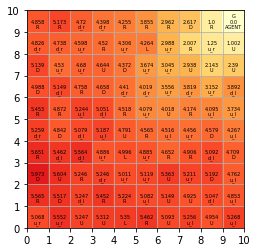

s:(1, 7) a:(0, 8) a':R
-----
s:(0, 8) a:(1, 8) a':D
-----
s:(1, 8) a:(1, 7) a':D
-----
s:(1, 7) a:(1, 6) a':U
-----
s:(1, 6) a:(1, 7) a':d_r
-----
s:(1, 7) a:(2, 6) a':u_l
-----
s:(2, 6) a:(1, 7) a':d_l
-----
s:(1, 7) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':U
-----
s:(0, 6) a:(0, 7) a':R
-----
s:(0, 7) a:(1, 7) a':L
-----
s:(1, 7) a:(0, 7) a':d_r
-----
s:(0, 7) a:(0, 7) a':d_r
-----
s:(0, 7) a:(1, 6) a':u_r
-----
s:(1, 6) a:(2, 7) a':d_r
-----
s:(2, 7) a:(3, 6) a':d_r
-----
s:(3, 6) a:(4, 5) a':L
-----
s:(4, 5) a:(3, 5) a':u_r
-----
s:(3, 5) a:(4, 6) a':u_l
-----
s:(4, 6) a:(3, 7) a':R
-----
s:(3, 7) a:(4, 7) a':u_r
-----
s:(4, 7) a:(5, 8) a':U
-----
s:(5, 8) a:(5, 9) a':R
-----
s:(5, 9) a:(6, 9) a':d_r
-----
s:(6, 9) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':D
-----


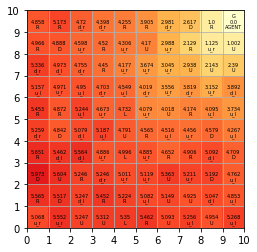

s:(8, 6) a:(9, 7) a':u_l
-----
s:(9, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


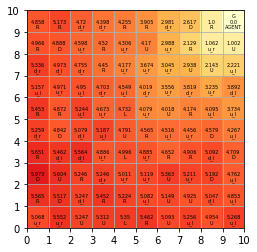

s:(2, 0) a:(1, 1) a':d_l
-----
s:(1, 1) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':L
-----
s:(0, 0) a:(0, 0) a':u_r
-----
s:(0, 0) a:(1, 1) a':u_r
-----
s:(1, 1) a:(2, 2) a':D
-----
s:(2, 2) a:(2, 1) a':U
-----
s:(2, 1) a:(2, 2) a':u_l
-----
s:(2, 2) a:(1, 3) a':U
-----
s:(1, 3) a:(1, 4) a':u_l
-----
s:(1, 4) a:(0, 5) a':R
-----
s:(0, 5) a:(1, 5) a':L
-----
s:(1, 5) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':d_r
-----
s:(0, 5) a:(1, 4) a':L
-----
s:(1, 4) a:(0, 4) a':L
-----
s:(0, 4) a:(0, 4) a':R
-----
s:(0, 4) a:(1, 4) a':d_r
-----
s:(1, 4) a:(2, 3) a':U
-----
s:(2, 3) a:(2, 4) a':D
-----
s:(2, 4) a:(2, 3) a':d_r
-----
s:(2, 3) a:(3, 2) a':R
-----
s:(3, 2) a:(4, 2) a':d_l
-----
s:(4, 2) a:(3, 1) a':U
-----
s:(3, 1) a:(3, 2) a':u_r
-----
s:(3, 2) a:(4, 3) a':u_l
-----
s:(4, 3) a:(3, 4) a':R
-----
s:(3, 4) a:(4, 4) a':L
-----
s:(4, 4) a:(3, 4) a':L
-----
s:(3, 4) a:(2, 4) a':u_r
-----
s:(2, 4) a:(3, 5) a':d_r
-----
s:(3, 5) a:(4, 4) a':d_l
-----
s:(4, 4) a:(3, 3) a':d_r
-----
s:(3, 3) a:

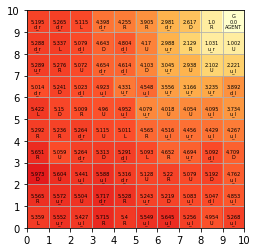

s:(8, 8) a:(9, 9) a':U
-----


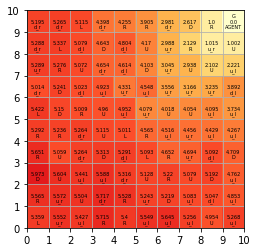

s:(6, 2) a:(5, 3) a':u_l
-----
s:(5, 3) a:(5, 3) a':u_l
-----
s:(5, 3) a:(4, 4) a':D
-----
s:(4, 4) a:(4, 3) a':d_l
-----
s:(4, 3) a:(4, 3) a':u_r
-----
s:(4, 3) a:(4, 3) a':u_r
-----
s:(4, 3) a:(5, 4) a':d_r
-----
s:(5, 4) a:(6, 3) a':L
-----
s:(6, 3) a:(5, 3) a':U
-----
s:(5, 3) a:(5, 4) a':d_l
-----
s:(5, 4) a:(4, 3) a':L
-----
s:(4, 3) a:(4, 3) a':U
-----
s:(4, 3) a:(4, 4) a':u_l
-----
s:(4, 4) a:(3, 5) a':u_r
-----
s:(3, 5) a:(4, 6) a':U
-----
s:(4, 6) a:(4, 7) a':R
-----
s:(4, 7) a:(5, 7) a':d_r
-----
s:(5, 7) a:(6, 6) a':u_r
-----
s:(6, 6) a:(7, 7) a':R
-----
s:(7, 7) a:(7, 7) a':R
-----
s:(7, 7) a:(8, 7) a':U
-----
s:(8, 7) a:(8, 8) a':d_l
-----
s:(8, 8) a:(7, 7) a':U
-----
s:(7, 7) a:(7, 8) a':L
-----
s:(7, 8) a:(6, 8) a':u_r
-----
s:(6, 8) a:(7, 9) a':U
-----
s:(7, 9) a:(7, 9) a':U
-----
s:(7, 9) a:(7, 9) a':u_l
-----
s:(7, 9) a:(7, 9) a':u_l
-----
s:(7, 9) a:(7, 9) a':R
-----
s:(7, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':d_l
-----


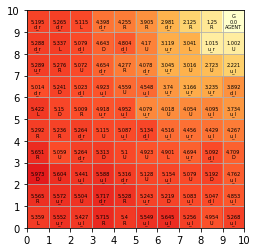

s:(2, 2) a:(3, 3) a':R
-----
s:(3, 3) a:(4, 3) a':d_r
-----
s:(4, 3) a:(5, 2) a':d_l
-----
s:(5, 2) a:(4, 1) a':U
-----
s:(4, 1) a:(4, 2) a':U
-----
s:(4, 2) a:(4, 3) a':D
-----
s:(4, 3) a:(4, 2) a':u_r
-----
s:(4, 2) a:(5, 3) a':D
-----
s:(5, 3) a:(5, 2) a':R
-----
s:(5, 2) a:(6, 2) a':u_l
-----
s:(6, 2) a:(5, 3) a':R
-----
s:(5, 3) a:(6, 3) a':u_l
-----
s:(6, 3) a:(5, 4) a':u_r
-----
s:(5, 4) a:(6, 5) a':d_l
-----
s:(6, 5) a:(5, 4) a':L
-----
s:(5, 4) a:(4, 4) a':R
-----
s:(4, 4) a:(5, 4) a':U
-----
s:(5, 4) a:(5, 5) a':U
-----
s:(5, 5) a:(5, 6) a':U
-----
s:(5, 6) a:(5, 7) a':L
-----
s:(5, 7) a:(4, 7) a':u_r
-----
s:(4, 7) a:(5, 8) a':d_r
-----
s:(5, 8) a:(6, 7) a':u_r
-----
s:(6, 7) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


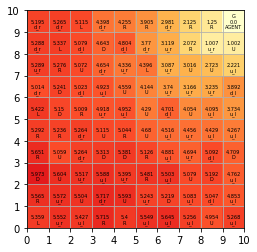

s:(1, 7) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':L
-----
s:(0, 8) a:(0, 8) a':u_l
-----
s:(0, 8) a:(0, 8) a':R
-----
s:(0, 8) a:(1, 8) a':D
-----
s:(1, 8) a:(1, 7) a':d_r
-----
s:(1, 7) a:(2, 6) a':R
-----
s:(2, 6) a:(3, 6) a':d_l
-----
s:(3, 6) a:(2, 5) a':U
-----
s:(2, 5) a:(2, 6) a':D
-----
s:(2, 6) a:(2, 5) a':d_l
-----
s:(2, 5) a:(1, 4) a':U
-----
s:(1, 4) a:(1, 5) a':u_r
-----
s:(1, 5) a:(2, 6) a':R
-----
s:(2, 6) a:(3, 6) a':u_r
-----
s:(3, 6) a:(4, 7) a':u_l
-----
s:(4, 7) a:(3, 8) a':d_r
-----
s:(3, 8) a:(4, 7) a':U
-----
s:(4, 7) a:(4, 8) a':R
-----
s:(4, 8) a:(5, 8) a':u_r
-----
s:(5, 8) a:(6, 9) a':R
-----
s:(6, 9) a:(7, 9) a':R
-----
s:(7, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


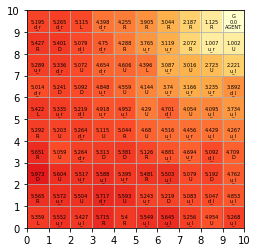

s:(8, 3) a:(9, 2) a':D
-----
s:(9, 2) a:(9, 1) a':d_r
-----
s:(9, 1) a:(9, 1) a':d_r
-----
s:(9, 1) a:(9, 1) a':L
-----
s:(9, 1) a:(8, 1) a':U
-----
s:(8, 1) a:(8, 2) a':U
-----
s:(8, 2) a:(8, 3) a':U
-----
s:(8, 3) a:(8, 4) a':u_r
-----
s:(8, 4) a:(8, 4) a':u_r
-----
s:(8, 4) a:(9, 5) a':u_r
-----
s:(9, 5) a:(9, 5) a':u_r
-----
s:(9, 5) a:(9, 5) a':U
-----
s:(9, 5) a:(9, 6) a':u_l
-----
s:(9, 6) a:(8, 7) a':u_r
-----
s:(8, 7) a:(8, 7) a':u_r
-----
s:(8, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


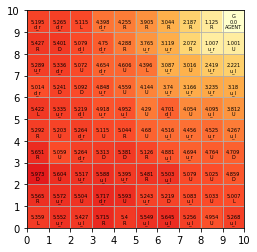

s:(3, 5) a:(3, 5) a':u_r
-----
s:(3, 5) a:(3, 5) a':L
-----
s:(3, 5) a:(2, 5) a':L
-----
s:(2, 5) a:(1, 5) a':u_l
-----
s:(1, 5) a:(0, 6) a':L
-----
s:(0, 6) a:(0, 6) a':L
-----
s:(0, 6) a:(0, 6) a':d_l
-----
s:(0, 6) a:(0, 6) a':d_l
-----
s:(0, 6) a:(0, 6) a':u_r
-----
s:(0, 6) a:(1, 7) a':u_r
-----
s:(1, 7) a:(2, 8) a':u_r
-----
s:(2, 8) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':L
-----
s:(3, 9) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':U
-----
s:(2, 9) a:(2, 9) a':R
-----
s:(2, 9) a:(3, 9) a':R
-----
s:(3, 9) a:(4, 9) a':L
-----
s:(4, 9) a:(4, 9) a':L
-----
s:(4, 9) a:(3, 9) a':u_r
-----
s:(3, 9) a:(3, 9) a':u_r
-----
s:(3, 9) a:(3, 9) a':U
-----
s:(3, 9) a:(3, 9) a':d_r
-----
s:(3, 9) a:(4, 8) a':u_l
-----
s:(4, 8) a:(3, 9) a':D
-----
s:(3, 9) a:(3, 8) a':U
-----
s:(3, 8) a:(3, 9) a':d_r
-----
s:(3, 9) a:(4, 8) a':U
-----
s:(4, 8) a:(4, 9) a':D
-----
s:(4, 9) a:(4, 8) a':L
-----
s:(4, 8) a:(3, 8) a':L
-----
s:(3, 8) a:(2, 8) a':u_r
-----
s:(2, 8) a:(2, 8)

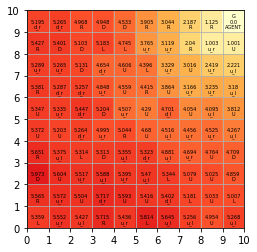

s:(7, 2) a:(6, 3) a':D
-----
s:(6, 3) a:(6, 3) a':D
-----
s:(6, 3) a:(6, 2) a':L
-----
s:(6, 2) a:(5, 2) a':L
-----
s:(5, 2) a:(4, 2) a':U
-----
s:(4, 2) a:(4, 2) a':R
-----
s:(4, 2) a:(4, 2) a':R
-----
s:(4, 2) a:(5, 2) a':u_r
-----
s:(5, 2) a:(6, 3) a':L
-----
s:(6, 3) a:(6, 3) a':d_r
-----
s:(6, 3) a:(7, 2) a':L
-----
s:(7, 2) a:(6, 2) a':D
-----
s:(6, 2) a:(6, 2) a':D
-----
s:(6, 2) a:(6, 1) a':L
-----
s:(6, 1) a:(5, 1) a':R
-----
s:(5, 1) a:(6, 1) a':U
-----
s:(6, 1) a:(6, 2) a':u_r
-----
s:(6, 2) a:(7, 3) a':L
-----
s:(7, 3) a:(6, 3) a':u_r
-----
s:(6, 3) a:(7, 4) a':U
-----
s:(7, 4) a:(7, 5) a':u_l
-----
s:(7, 5) a:(6, 6) a':R
-----
s:(6, 6) a:(7, 6) a':u_r
-----
s:(7, 6) a:(8, 7) a':u_l
-----
s:(8, 7) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


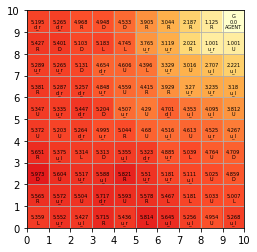

s:(7, 6) a:(8, 7) a':U
-----
s:(8, 7) a:(8, 8) a':u_l
-----
s:(8, 8) a:(7, 9) a':R
-----
s:(7, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


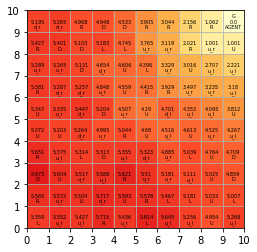

s:(6, 3) a:(7, 3) a':D
-----
s:(7, 3) a:(7, 2) a':d_r
-----
s:(7, 2) a:(8, 1) a':R
-----
s:(8, 1) a:(9, 1) a':d_l
-----
s:(9, 1) a:(8, 0) a':u_r
-----
s:(8, 0) a:(9, 1) a':U
-----
s:(9, 1) a:(9, 1) a':U
-----
s:(9, 1) a:(9, 2) a':u_r
-----
s:(9, 2) a:(9, 2) a':u_r
-----
s:(9, 2) a:(9, 2) a':U
-----
s:(9, 2) a:(9, 3) a':u_l
-----
s:(9, 3) a:(8, 4) a':d_r
-----
s:(8, 4) a:(8, 4) a':d_r
-----
s:(8, 4) a:(8, 4) a':L
-----
s:(8, 4) a:(7, 4) a':u_l
-----
s:(7, 4) a:(6, 5) a':u_r
-----
s:(6, 5) a:(7, 6) a':u_r
-----
s:(7, 6) a:(8, 7) a':u_r
-----
s:(8, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


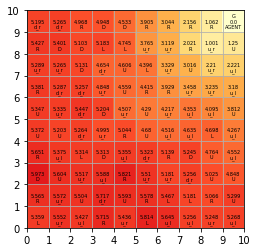

s:(4, 6) a:(5, 6) a':L
-----
s:(5, 6) a:(4, 6) a':D
-----
s:(4, 6) a:(4, 5) a':U
-----
s:(4, 5) a:(4, 6) a':u_l
-----
s:(4, 6) a:(3, 7) a':u_l
-----
s:(3, 7) a:(2, 8) a':d_r
-----
s:(2, 8) a:(2, 8) a':d_r
-----
s:(2, 8) a:(3, 7) a':R
-----
s:(3, 7) a:(4, 7) a':d_r
-----
s:(4, 7) a:(5, 6) a':u_r
-----
s:(5, 6) a:(6, 7) a':d_r
-----
s:(6, 7) a:(7, 6) a':u_r
-----
s:(7, 6) a:(8, 7) a':u_r
-----
s:(8, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


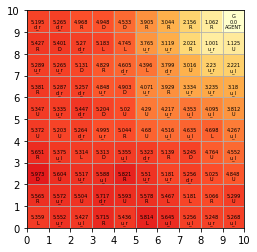

s:(7, 7) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


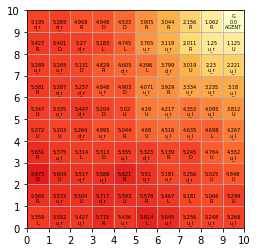

s:(5, 8) a:(5, 7) a':u_r
-----
s:(5, 7) a:(6, 8) a':d_l
-----
s:(6, 8) a:(5, 7) a':U
-----
s:(5, 7) a:(5, 8) a':u_r
-----
s:(5, 8) a:(6, 9) a':d_l
-----
s:(6, 9) a:(5, 8) a':d_r
-----
s:(5, 8) a:(6, 7) a':L
-----
s:(6, 7) a:(6, 7) a':L
-----
s:(6, 7) a:(5, 7) a':u_l
-----
s:(5, 7) a:(4, 8) a':d_r
-----
s:(4, 8) a:(5, 7) a':u_r
-----
s:(5, 7) a:(5, 7) a':u_r
-----
s:(5, 7) a:(6, 8) a':U
-----
s:(6, 8) a:(6, 9) a':d_r
-----
s:(6, 9) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


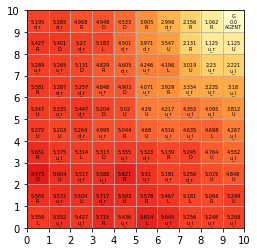

s:(8, 8) a:(9, 9) a':U
-----


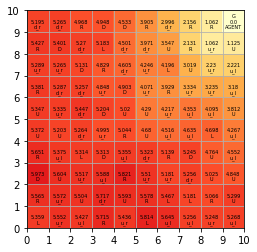

s:(0, 7) a:(0, 7) a':D
-----
s:(0, 7) a:(0, 6) a':D
-----
s:(0, 6) a:(0, 5) a':d_l
-----
s:(0, 5) a:(0, 5) a':d_l
-----
s:(0, 5) a:(0, 5) a':u_r
-----
s:(0, 5) a:(1, 6) a':u_r
-----
s:(1, 6) a:(2, 7) a':u_r
-----
s:(2, 7) a:(3, 8) a':R
-----
s:(3, 8) a:(4, 8) a':D
-----
s:(4, 8) a:(4, 7) a':R
-----
s:(4, 7) a:(5, 7) a':R
-----
s:(5, 7) a:(6, 7) a':U
-----
s:(6, 7) a:(6, 8) a':u_r
-----
s:(6, 8) a:(7, 9) a':R
-----
s:(7, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


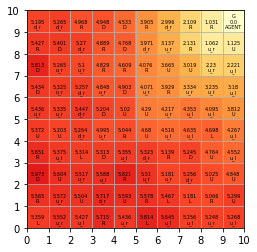

s:(1, 1) a:(2, 1) a':u_l
-----
s:(2, 1) a:(1, 2) a':d_r
-----
s:(1, 2) a:(2, 1) a':L
-----
s:(2, 1) a:(1, 1) a':d_r
-----
s:(1, 1) a:(2, 0) a':u_r
-----
s:(2, 0) a:(3, 1) a':L
-----
s:(3, 1) a:(2, 1) a':D
-----
s:(2, 1) a:(2, 0) a':L
-----
s:(2, 0) a:(1, 0) a':L
-----
s:(1, 0) a:(0, 0) a':d_r
-----
s:(0, 0) a:(0, 0) a':d_r
-----
s:(0, 0) a:(0, 0) a':R
-----
s:(0, 0) a:(1, 0) a':R
-----
s:(1, 0) a:(2, 0) a':D
-----
s:(2, 0) a:(2, 0) a':D
-----
s:(2, 0) a:(2, 0) a':U
-----
s:(2, 0) a:(2, 1) a':R
-----
s:(2, 1) a:(3, 1) a':d_l
-----
s:(3, 1) a:(2, 0) a':R
-----
s:(2, 0) a:(3, 0) a':u_l
-----
s:(3, 0) a:(2, 1) a':u_r
-----
s:(2, 1) a:(3, 2) a':U
-----
s:(3, 2) a:(3, 3) a':D
-----
s:(3, 3) a:(3, 2) a':R
-----
s:(3, 2) a:(4, 2) a':d_l
-----
s:(4, 2) a:(3, 1) a':u_l
-----
s:(3, 1) a:(2, 2) a':U
-----
s:(2, 2) a:(2, 3) a':R
-----
s:(2, 3) a:(3, 3) a':D
-----
s:(3, 3) a:(3, 2) a':u_r
-----
s:(3, 2) a:(4, 3) a':u_r
-----
s:(4, 3) a:(5, 4) a':R
-----
s:(5, 4) a:(6, 4) a':U
-----
s:(6, 4) a:(6, 5)

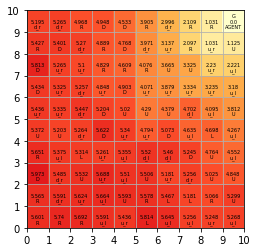

s:(3, 8) a:(2, 7) a':d_r
-----
s:(2, 7) a:(3, 6) a':L
-----
s:(3, 6) a:(2, 6) a':u_r
-----
s:(2, 6) a:(3, 7) a':u_r
-----
s:(3, 7) a:(4, 8) a':R
-----
s:(4, 8) a:(5, 8) a':u_l
-----
s:(5, 8) a:(4, 9) a':d_r
-----
s:(4, 9) a:(4, 9) a':d_r
-----
s:(4, 9) a:(5, 8) a':d_l
-----
s:(5, 8) a:(4, 7) a':u_r
-----
s:(4, 7) a:(5, 8) a':u_l
-----
s:(5, 8) a:(4, 9) a':U
-----
s:(4, 9) a:(4, 9) a':U
-----
s:(4, 9) a:(4, 9) a':d_l
-----
s:(4, 9) a:(3, 8) a':D
-----
s:(3, 8) a:(3, 7) a':D
-----
s:(3, 7) a:(3, 6) a':u_l
-----
s:(3, 6) a:(2, 7) a':R
-----
s:(2, 7) a:(3, 7) a':U
-----
s:(3, 7) a:(3, 8) a':u_l
-----
s:(3, 8) a:(2, 9) a':d_r
-----
s:(2, 9) a:(3, 8) a':u_r
-----
s:(3, 8) a:(4, 9) a':u_r
-----
s:(4, 9) a:(4, 9) a':u_r
-----
s:(4, 9) a:(4, 9) a':R
-----
s:(4, 9) a:(5, 9) a':d_r
-----
s:(5, 9) a:(6, 8) a':u_r
-----
s:(6, 8) a:(7, 9) a':R
-----
s:(7, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


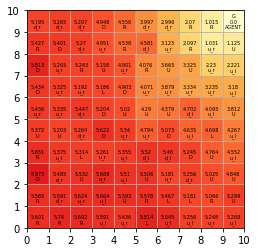

s:(3, 8) a:(4, 7) a':L
-----
s:(4, 7) a:(3, 7) a':d_r
-----
s:(3, 7) a:(4, 6) a':u_r
-----
s:(4, 6) a:(5, 7) a':d_l
-----
s:(5, 7) a:(4, 6) a':L
-----
s:(4, 6) a:(3, 6) a':R
-----
s:(3, 6) a:(3, 6) a':R
-----
s:(3, 6) a:(3, 6) a':U
-----
s:(3, 6) a:(3, 7) a':L
-----
s:(3, 7) a:(2, 7) a':L
-----
s:(2, 7) a:(1, 7) a':d_l
-----
s:(1, 7) a:(0, 6) a':d_r
-----
s:(0, 6) a:(1, 5) a':R
-----
s:(1, 5) a:(2, 5) a':u_r
-----
s:(2, 5) a:(3, 6) a':d_r
-----
s:(3, 6) a:(4, 5) a':d_r
-----
s:(4, 5) a:(5, 4) a':D
-----
s:(5, 4) a:(5, 3) a':u_r
-----
s:(5, 3) a:(6, 4) a':u_r
-----
s:(6, 4) a:(7, 5) a':U
-----
s:(7, 5) a:(7, 5) a':U
-----
s:(7, 5) a:(7, 6) a':u_r
-----
s:(7, 6) a:(8, 7) a':u_r
-----
s:(8, 7) a:(9, 8) a':U
-----
s:(9, 8) a:(9, 9) a':U
-----


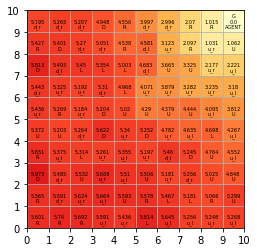

s:(5, 4) a:(5, 5) a':L
-----
s:(5, 5) a:(4, 5) a':D
-----
s:(4, 5) a:(4, 4) a':U
-----
s:(4, 4) a:(4, 5) a':R
-----
s:(4, 5) a:(5, 5) a':u_r
-----
s:(5, 5) a:(6, 6) a':d_r
-----
s:(6, 6) a:(7, 5) a':D
-----
s:(7, 5) a:(7, 4) a':L
-----
s:(7, 4) a:(7, 4) a':L
-----
s:(7, 4) a:(6, 4) a':u_l
-----
s:(6, 4) a:(5, 5) a':u_l
-----
s:(5, 5) a:(4, 6) a':d_r
-----
s:(4, 6) a:(5, 5) a':R
-----
s:(5, 5) a:(5, 5) a':R
-----
s:(5, 5) a:(6, 5) a':L
-----
s:(6, 5) a:(5, 5) a':U
-----
s:(5, 5) a:(5, 6) a':D
-----
s:(5, 6) a:(5, 5) a':d_r
-----
s:(5, 5) a:(6, 4) a':U
-----
s:(6, 4) a:(6, 4) a':d_r
-----
s:(6, 4) a:(7, 3) a':U
-----
s:(7, 3) a:(7, 4) a':D
-----
s:(7, 4) a:(7, 3) a':d_r
-----
s:(7, 3) a:(8, 2) a':u_l
-----
s:(8, 2) a:(7, 3) a':u_l
-----
s:(7, 3) a:(6, 4) a':d_l
-----
s:(6, 4) a:(5, 3) a':U
-----
s:(5, 3) a:(5, 4) a':d_r
-----
s:(5, 4) a:(5, 4) a':d_r
-----
s:(5, 4) a:(6, 3) a':u_l
-----
s:(6, 3) a:(5, 4) a':d_r
-----
s:(5, 4) a:(6, 3) a':u_r
-----
s:(6, 3) a:(6, 3) a':D
-----
s:(6, 3) a:

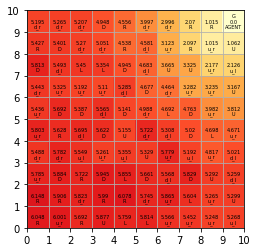

s:(3, 2) a:(3, 2) a':u_l
-----
s:(3, 2) a:(2, 3) a':u_r
-----
s:(2, 3) a:(3, 4) a':R
-----
s:(3, 4) a:(4, 4) a':L
-----
s:(4, 4) a:(3, 4) a':u_r
-----
s:(3, 4) a:(4, 5) a':D
-----
s:(4, 5) a:(4, 4) a':u_l
-----
s:(4, 4) a:(3, 5) a':u_l
-----
s:(3, 5) a:(3, 5) a':u_l
-----
s:(3, 5) a:(2, 6) a':U
-----
s:(2, 6) a:(2, 7) a':U
-----
s:(2, 7) a:(2, 7) a':U
-----
s:(2, 7) a:(2, 8) a':R
-----
s:(2, 8) a:(3, 8) a':R
-----
s:(3, 8) a:(4, 8) a':L
-----
s:(4, 8) a:(3, 8) a':u_r
-----
s:(3, 8) a:(4, 9) a':u_l
-----
s:(4, 9) a:(4, 9) a':u_l
-----
s:(4, 9) a:(4, 9) a':D
-----
s:(4, 9) a:(4, 8) a':u_r
-----
s:(4, 8) a:(5, 9) a':R
-----
s:(5, 9) a:(6, 9) a':d_r
-----
s:(6, 9) a:(6, 9) a':d_r
-----
s:(6, 9) a:(7, 8) a':R
-----
s:(7, 8) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


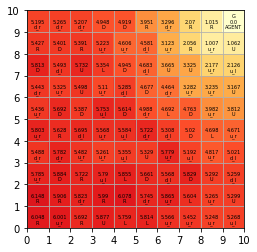

s:(8, 9) a:(9, 9) a':U
-----


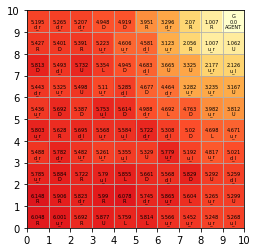

s:(9, 3) a:(9, 3) a':u_r
-----
s:(9, 3) a:(9, 3) a':U
-----
s:(9, 3) a:(9, 4) a':L
-----
s:(9, 4) a:(8, 4) a':R
-----
s:(8, 4) a:(9, 4) a':D
-----
s:(9, 4) a:(9, 3) a':u_l
-----
s:(9, 3) a:(8, 4) a':u_l
-----
s:(8, 4) a:(7, 5) a':R
-----
s:(7, 5) a:(8, 5) a':u_r
-----
s:(8, 5) a:(9, 6) a':U
-----
s:(9, 6) a:(9, 7) a':u_l
-----
s:(9, 7) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


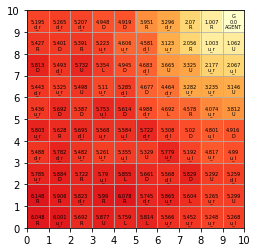

s:(0, 7) a:(0, 7) a':u_l
-----
s:(0, 7) a:(0, 7) a':U
-----
s:(0, 7) a:(0, 7) a':U
-----
s:(0, 7) a:(0, 8) a':U
-----
s:(0, 8) a:(0, 9) a':u_l
-----
s:(0, 9) a:(0, 9) a':R
-----
s:(0, 9) a:(1, 9) a':U
-----
s:(1, 9) a:(1, 9) a':L
-----
s:(1, 9) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':u_l
-----
s:(1, 9) a:(1, 9) a':R
-----
s:(1, 9) a:(2, 9) a':d_l
-----
s:(2, 9) a:(1, 8) a':u_r
-----
s:(1, 8) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 9) a':D
-----
s:(2, 9) a:(2, 8) a':u_l
-----
s:(2, 8) a:(1, 9) a':R
-----
s:(1, 9) a:(2, 9) a':L
-----
s:(2, 9) a:(1, 9) a':d_l
-----
s:(1, 9) a:(1, 9) a':d_l
-----
s:(1, 9) a:(0, 8) a':d_l
-----
s:(0, 8) a:(0, 8) a':d_l
-----
s:(0, 8) a:(0, 8) a':D
-----
s:(0, 8) a:(0, 7) a':u_r
-----
s:(0, 7) a:(0, 7) a':u_r
-----
s:(0, 7) a:(1, 8) a':R
-----
s:(1, 8) a:(2, 8) a':L
-----
s:(2, 8) a:(1, 8) a':d_r
-----
s:(1, 8) a:(2, 7) a':u_l
-----
s:(2, 7) a:(1, 8) a':d_l
-----
s:(1, 8) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':d_l
-----
s:(0, 7) a:(0, 7) a':R
-----
s:(0, 7

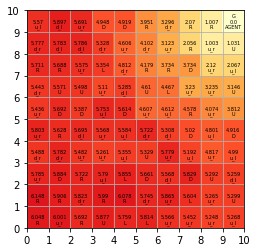

s:(0, 5) a:(0, 5) a':u_l
-----
s:(0, 5) a:(0, 5) a':d_r
-----
s:(0, 5) a:(1, 4) a':u_l
-----
s:(1, 4) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':L
-----
s:(0, 6) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':u_l
-----
s:(0, 6) a:(0, 6) a':U
-----
s:(0, 6) a:(0, 7) a':d_r
-----
s:(0, 7) a:(1, 6) a':L
-----
s:(1, 6) a:(0, 6) a':u_r
-----
s:(0, 6) a:(1, 7) a':D
-----
s:(1, 7) a:(1, 6) a':d_l
-----
s:(1, 6) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':L
-----
s:(0, 5) a:(0, 5) a':U
-----
s:(0, 5) a:(0, 6) a':R
-----
s:(0, 6) a:(1, 6) a':D
-----
s:(1, 6) a:(1, 5) a':U
-----
s:(1, 5) a:(1, 6) a':d_r
-----
s:(1, 6) a:(2, 5) a':R
-----
s:(2, 5) a:(3, 5) a':d_r
-----
s:(3, 5) a:(4, 4) a':d_r
-----
s:(4, 4) a:(5, 3) a':L
-----
s:(5, 3) a:(4, 3) a':U
-----
s:(4, 3) a:(4, 4) a':U
-----
s:(4, 4) a:(4, 5) a':u_r
-----
s:(4, 5) a:(5, 6) a':u_r
-----
s:(5, 6) a:(6, 7) a':u_r
-----
s:(6, 7) a:(7, 8) a':R
-----
s:(7, 8) a:(7, 8) a':u_l
-----
s:(7, 8) a:(6, 9) a':u_r
-----
s:(6, 9) a:(6, 9) a':u_r
-----
s:(6, 9) 

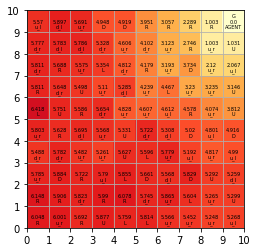

s:(7, 1) a:(8, 1) a':U
-----
s:(8, 1) a:(8, 2) a':d_r
-----
s:(8, 2) a:(9, 1) a':u_r
-----
s:(9, 1) a:(9, 1) a':u_r
-----
s:(9, 1) a:(9, 1) a':u_r
-----
s:(9, 1) a:(9, 1) a':u_r
-----
s:(9, 1) a:(9, 1) a':D
-----
s:(9, 1) a:(9, 0) a':D
-----
s:(9, 0) a:(9, 0) a':D
-----
s:(9, 0) a:(9, 0) a':U
-----
s:(9, 0) a:(9, 1) a':u_l
-----
s:(9, 1) a:(8, 2) a':R
-----
s:(8, 2) a:(9, 2) a':u_l
-----
s:(9, 2) a:(8, 3) a':D
-----
s:(8, 3) a:(8, 2) a':u_l
-----
s:(8, 2) a:(7, 3) a':u_r
-----
s:(7, 3) a:(8, 4) a':U
-----
s:(8, 4) a:(8, 5) a':L
-----
s:(8, 5) a:(7, 5) a':d_r
-----
s:(7, 5) a:(8, 4) a':d_l
-----
s:(8, 4) a:(7, 3) a':d_l
-----
s:(7, 3) a:(6, 2) a':u_r
-----
s:(6, 2) a:(7, 3) a':R
-----
s:(7, 3) a:(8, 3) a':u_r
-----
s:(8, 3) a:(9, 4) a':U
-----
s:(9, 4) a:(9, 5) a':u_l
-----
s:(9, 5) a:(8, 6) a':D
-----
s:(8, 6) a:(8, 5) a':R
-----
s:(8, 5) a:(9, 5) a':L
-----
s:(9, 5) a:(9, 5) a':L
-----
s:(9, 5) a:(8, 5) a':L
-----
s:(8, 5) a:(7, 5) a':u_r
-----
s:(7, 5) a:(8, 6) a':u_r
-----
s:(8, 6) 

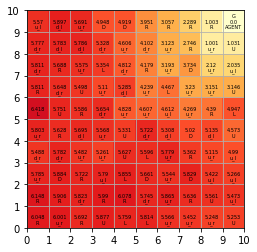

s:(5, 6) a:(4, 6) a':U
-----
s:(4, 6) a:(4, 7) a':U
-----
s:(4, 7) a:(4, 8) a':d_r
-----
s:(4, 8) a:(5, 7) a':u_r
-----
s:(5, 7) a:(6, 8) a':u_r
-----
s:(6, 8) a:(7, 9) a':L
-----
s:(7, 9) a:(6, 9) a':R
-----
s:(6, 9) a:(7, 9) a':u_r
-----
s:(7, 9) a:(7, 9) a':u_r
-----
s:(7, 9) a:(7, 9) a':d_r
-----
s:(7, 9) a:(8, 8) a':u_r
-----
s:(8, 8) a:(9, 9) a':U
-----


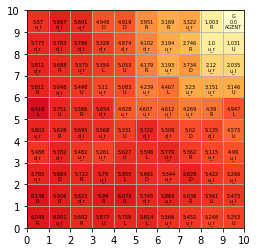

s:(6, 7) a:(7, 8) a':u_l
-----
s:(7, 8) a:(6, 9) a':D
-----
s:(6, 9) a:(6, 9) a':D
-----
s:(6, 9) a:(6, 8) a':L
-----
s:(6, 8) a:(5, 8) a':u_r
-----
s:(5, 8) a:(6, 9) a':R
-----
s:(6, 9) a:(7, 9) a':R
-----
s:(7, 9) a:(8, 9) a':U
-----
s:(8, 9) a:(8, 9) a':R
-----
s:(8, 9) a:(9, 9) a':U
-----


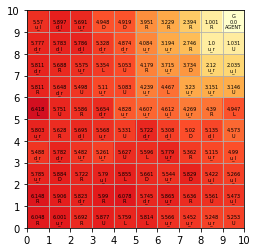

s:(9, 1) a:(9, 1) a':R
-----
s:(9, 1) a:(9, 1) a':R
-----
s:(9, 1) a:(9, 1) a':D
-----
s:(9, 1) a:(9, 0) a':L
-----
s:(9, 0) a:(8, 0) a':R
-----
s:(8, 0) a:(9, 0) a':R
-----
s:(9, 0) a:(9, 0) a':R
-----
s:(9, 0) a:(9, 0) a':d_r
-----
s:(9, 0) a:(9, 0) a':d_r
-----
s:(9, 0) a:(9, 0) a':u_r
-----
s:(9, 0) a:(9, 0) a':u_r
-----
s:(9, 0) a:(9, 0) a':L
-----
s:(9, 0) a:(8, 0) a':L
-----
s:(8, 0) a:(7, 0) a':L
-----
s:(7, 0) a:(6, 0) a':d_l
-----
s:(6, 0) a:(6, 0) a':d_l
-----
s:(6, 0) a:(6, 0) a':U
-----
s:(6, 0) a:(6, 0) a':U
-----
s:(6, 0) a:(6, 1) a':R
-----
s:(6, 1) a:(6, 1) a':R
-----
s:(6, 1) a:(7, 1) a':d_r
-----
s:(7, 1) a:(7, 1) a':d_r
-----
s:(7, 1) a:(8, 0) a':d_r
-----
s:(8, 0) a:(8, 0) a':d_r
-----
s:(8, 0) a:(8, 0) a':U
-----
s:(8, 0) a:(8, 0) a':U
-----
s:(8, 0) a:(8, 1) a':d_l
-----
s:(8, 1) a:(7, 0) a':d_l
-----
s:(7, 0) a:(7, 0) a':d_l
-----
s:(7, 0) a:(7, 0) a':u_l
-----
s:(7, 0) a:(6, 1) a':d_r
-----
s:(6, 1) a:(7, 0) a':U
-----
s:(7, 0) a:(7, 0) a':U
-----
s:(7, 0) a:(7

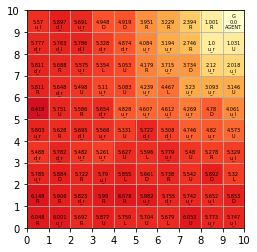

s:(2, 0) a:(2, 0) a':d_l
-----
s:(2, 0) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':d_r
-----
s:(2, 0) a:(2, 0) a':u_l
-----
s:(2, 0) a:(1, 1) a':d_l
-----
s:(1, 1) a:(1, 1) a':d_l
-----
s:(1, 1) a:(0, 0) a':u_r
-----
s:(0, 0) a:(1, 1) a':u_r
-----
s:(1, 1) a:(2, 2) a':L
-----
s:(2, 2) a:(1, 2) a':L
-----
s:(1, 2) a:(0, 2) a':R
-----
s:(0, 2) a:(1, 2) a':u_r
-----
s:(1, 2) a:(2, 3) a':D
-----
s:(2, 3) a:(2, 2) a':d_r
-----
s:(2, 2) a:(2, 2) a':d_r
-----
s:(2, 2) a:(3, 1) a':L
-----
s:(3, 1) a:(2, 1) a':U
-----
s:(2, 1) a:(2, 1) a':U
-----
s:(2, 1) a:(2, 2) a':u_l
-----
s:(2, 2) a:(1, 3) a':R
-----
s:(1, 3) a:(1, 3) a':R
-----
s:(1, 3) a:(2, 3) a':d_r
-----
s:(2, 3) a:(3, 2) a':R
-----
s:(3, 2) a:(4, 2) a':d_r
-----
s:(4, 2) a:(5, 1) a':D
-----
s:(5, 1) a:(5, 0) a':d_r
-----
s:(5, 0) a:(5, 0) a':D
-----
s:(5, 0) a:(5, 0) a':d_l
-----
s:(5, 0) a:(5, 0) a':d_l
-----
s:(5, 0) a:(5, 0) a':u_r
-----
s:(5, 0) a:(5, 0) a':u_r
-----
s:(5, 0) a:(6, 1) a':u_l
-----
s:(6, 1) a:(5, 2) a':d_r
-----
s

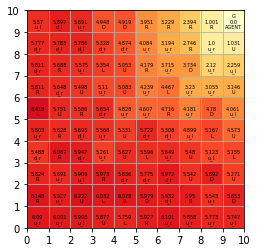

In [8]:
alpha = 0.5
gamma = 1.0

def sarsa(s_pos,a):
    s = states[s_pos[0]][s_pos[1]]
    s_next_pos = state_transition(s_pos,a)
    s_next = states[s_next_pos[0]][s_next_pos[1]]
    a_next = e_greedy(s_next)
    
    q = (1.0 - alpha) * s.Q[a] + alpha * (1.0 + gamma * s_next.Q[a_next])
    print("s:" + str(s_pos) + " a:" + str(s_next_pos) + " a':" + a_next)
    print("-----")
    return s_next_pos, a_next, q
            
def one_trial_sarsa():
    agent.pos = (random.randrange(size),random.randrange(size))
    a = e_greedy(states[agent.pos[0]][agent.pos[1]])
    if states[agent.pos[0]][agent.pos[1]].goal:
        return
    
    while True:
        s_next, a_next, q = sarsa(agent.pos, a)
        states[agent.pos[0]][agent.pos[1]].Q[a] = q
        agent.pos = s_next
        a = a_next
        if states[agent.pos[0]][agent.pos[1]].goal:
            break

for i in range(100):
    one_trial_sarsa()
    draw("all")